### ============================================================================
### NOTEBOOK 03: MACHINE LEARNING MODELING
###
### This notebook covers:
###   - Model 1: Customer Churn Prediction (Classification)
###   - Model 2: Customer Lifetime Value Prediction (Regression)
###   - Model 3: Revenue Forecasting (Time Series)
###   - Model 4: Review Score Prediction (Regression/Classification)
###   - Model 5: Product Recommendations (Collaborative Filtering)
###
### Each model includes:
###   • Data preparation & feature selection
###   • Baseline model
###   • Multiple algorithms (Logistic, Random Forest, XGBoost, LightGBM)
###   • Hyperparameter tuning (GridSearchCV/RandomizedSearchCV)
###   • Model evaluation & comparison
###   • Feature importance analysis
###   • Model saving for deployment
### ============================================================================

In [1]:
# Setup and Imports
# ============================================================================
# Import all necessary libraries for machine learning
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
import joblib
import json

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

# Feature importance
import shap

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Create directories
Path('models/trained').mkdir(parents=True, exist_ok=True)
Path('reports/figures/models').mkdir(parents=True, exist_ok=True)
Path('reports/model_evaluation').mkdir(parents=True, exist_ok=True)

print("✅ Libraries imported successfully")
print(f"📅 Modeling date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n🔧 Scikit-learn version: {sklearn.__version__ if 'sklearn' in dir() else 'N/A'}")
print(f"🔧 XGBoost version: {xgb.__version__}")
print(f"🔧 LightGBM version: {lgb.__version__}")

✅ Libraries imported successfully
📅 Modeling date: 2025-11-09 22:09:49

🔧 Scikit-learn version: N/A
🔧 XGBoost version: 2.0.3
🔧 LightGBM version: 4.1.0


In [2]:
# Load Feature Datasets
# ============================================================================
# Load all feature-engineered datasets from Notebook 02
# ============================================================================

print("\n📂 LOADING FEATURE DATASETS")
print("="*80)

# Load customer features
customer_features = pd.read_csv('data/features/customer_features.csv')
print(f"✅ Customer features: {customer_features.shape}")

# Load product features
product_features = pd.read_csv('data/features/product_features.csv')
print(f"✅ Product features: {product_features.shape}")

# Load order features
order_features = pd.read_csv('data/features/order_features_enhanced.csv')
# Convert dates back to datetime
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date',
              'order_estimated_delivery_date', 'first_order_date', 'review_creation_date']
for col in date_cols:
    if col in order_features.columns:
        order_features[col] = pd.to_datetime(order_features[col], errors='coerce')
print(f"✅ Order features: {order_features.shape}")

# Load time series features
timeseries_features = pd.read_csv('data/features/daily_timeseries_features_clean.csv')
timeseries_features['date'] = pd.to_datetime(timeseries_features['date'])
print(f"✅ Time series features: {timeseries_features.shape}")

# Load seller features
seller_features = pd.read_csv('data/features/seller_features.csv')
print(f"✅ Seller features: {seller_features.shape}")

print(f"\n✅ All feature datasets loaded successfully!")


📂 LOADING FEATURE DATASETS
✅ Customer features: (75324, 22)
✅ Product features: (32951, 24)
✅ Order features: (96476, 69)
✅ Time series features: (582, 40)
✅ Seller features: (3095, 15)

✅ All feature datasets loaded successfully!


In [3]:
# Model 1 - Customer Churn Prediction (Setup)
# ============================================================================
# Problem: Predict which customers will churn (no purchase in 90 days)
# Type: Binary Classification
# Target: is_churned (0/1)
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb

print("\n" + "="*80)
print(" "*20 + "MODEL 1: CUSTOMER CHURN PREDICTION")
print("="*80)

print("\n🎯 PROBLEM DEFINITION:")
print("   Type: Binary Classification")
print("   Target: is_churned (1 = churned, 0 = active)")
print("   Goal: Identify customers at risk of churning")
print("   Business Impact: Retention campaigns, personalized offers")

# ============================================================================
# LOAD DATA (from corrected feature engineering)
# ============================================================================
print("\n📁 Loading customer features...")
customer_features = pd.read_csv('data/features/customer_features.csv')

print(f"\n📊 Dataset Overview:")
print(f"   Total customers: {len(customer_features):,}")
print(f"   Total columns: {customer_features.shape[1]}")
print(f"   Churned: {customer_features['is_churned'].sum():,} ({customer_features['is_churned'].mean()*100:.1f}%)")
print(f"   Active: {(customer_features['is_churned']==0).sum():,} ({(customer_features['is_churned']==0).mean()*100:.1f}%)")

# ============================================================================
# SELECT FEATURES (NO LEAKY FEATURES!)
# ============================================================================
print("\n📋 Feature Selection (NO LEAKAGE):")

# Define feature columns (ONLY non-leaky features)
feature_cols = [
    # Behavioral features (OK)
    'total_orders',          # ✓ Historical behavior
    'total_spent',           # ✓ Historical behavior
    'avg_order_value',       # ✓ Historical behavior
    'order_value_std',       # ✓ Historical behavior
    'avg_items_per_order',   # ✓ Historical behavior
    'total_items_bought',    # ✓ Historical behavior
    'total_reviews',         # ✓ Historical behavior
    'avg_review_given',      # ✓ Historical behavior
    
    # Service quality features (OK)
    'late_delivery_rate',    # ✓ Historical experience
    'avg_delivery_time',     # ✓ Historical experience
    
    # Payment behavior (OK)
    'avg_installments',      # ✓ Historical behavior
    
    # RFM scores (OK - calculated from historical data)
    'F_score',               # ✓ Frequency score
    'M_score',               # ✓ Monetary score
    'R_score',               # ✓ Recency score (from historical cutoff)
    'RFM_numeric',           # ✓ Combined score
    
    # Purchase frequency (OK)
    'purchase_frequency_rate' # ✓ Orders per day of tenure
]

# Check which features are available
available_features = [col for col in feature_cols if col in customer_features.columns]
missing_features = [col for col in feature_cols if col not in customer_features.columns]

print(f"   Available features: {len(available_features)}")
if missing_features:
    print(f"   Missing features: {missing_features}")

# Also exclude ID and categorical columns
exclude_cols = ['customer_unique_id', 'segment', 'clv_segment', 'is_churned']

# Prepare features and target
X = customer_features[available_features].copy()
y = customer_features['is_churned'].copy()

print(f"\n   Final feature count: {X.shape[1]}")
print(f"\n   Features used:")
for i, col in enumerate(X.columns, 1):
    print(f"      {i:2d}. {col}")

# ============================================================================
# HANDLE MISSING VALUES
# ============================================================================
print("\n🔧 Handling missing values...")
missing_before = X.isnull().sum().sum()
print(f"   Missing values before: {missing_before}")

# Fill missing with median (conservative approach)
X = X.fillna(X.median())

missing_after = X.isnull().sum().sum()
print(f"   Missing values after: {missing_after}")

# ============================================================================
# CHECK CLASS BALANCE
# ============================================================================
print("\n⚖️ Class Balance:")
print(y.value_counts())
print(f"   Churn rate: {y.mean()*100:.2f}%")

# If extremely imbalanced, consider undersampling or SMOTE
if y.mean() > 0.75 or y.mean() < 0.25:
    print("\n   ⚠️ WARNING: Severe class imbalance detected!")
    print("   Consider balancing techniques (SMOTE, undersampling)")
    
    # Optional: Apply undersampling here
    from sklearn.utils import resample
    
    # Combine X and y
    data = pd.concat([X, y], axis=1)
    
    # Separate classes
    data_majority = data[data['is_churned'] == 1]
    data_minority = data[data['is_churned'] == 0]
    
    # Undersample majority (2:1 ratio)
    data_majority_downsampled = resample(
        data_majority,
        replace=False,
        n_samples=len(data_minority) * 2,
        random_state=42
    )
    
    # Combine
    data_balanced = pd.concat([data_minority, data_majority_downsampled])
    data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split back
    X = data_balanced.drop('is_churned', axis=1)
    y = data_balanced['is_churned']
    
    print(f"\n   After balancing:")
    print(y.value_counts())
    print(f"   Churn rate: {y.mean()*100:.2f}%")

# ============================================================================
# TRAIN-TEST SPLIT
# ============================================================================
print("\n📊 Creating train-test split...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Training set: {X_train.shape[0]:,} samples ({y_train.mean()*100:.1f}% churn)")
print(f"   Test set: {X_test.shape[0]:,} samples ({y_test.mean()*100:.1f}% churn)")

# ============================================================================
# FEATURE SCALING (for Logistic Regression)
# ============================================================================
print("\n📏 Scaling features...")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("   ✓ Features scaled using StandardScaler")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✅ DATA PREPARATION COMPLETE")
print("="*80)

print(f"\n📊 Summary:")
print(f"   Total samples: {len(X):,}")
print(f"   Features: {X.shape[1]}")
print(f"   Train samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Class balance (train): {y_train.value_counts().to_dict()}")

print("\n🎯 Ready for model training!")
print("   Next: Run baseline and initial models (Document 7)")


                    MODEL 1: CUSTOMER CHURN PREDICTION

🎯 PROBLEM DEFINITION:
   Type: Binary Classification
   Target: is_churned (1 = churned, 0 = active)
   Goal: Identify customers at risk of churning
   Business Impact: Retention campaigns, personalized offers

📁 Loading customer features...

📊 Dataset Overview:
   Total customers: 75,324
   Total columns: 22
   Churned: 74,903 (99.4%)
   Active: 421 (0.6%)

📋 Feature Selection (NO LEAKAGE):
   Available features: 16

   Final feature count: 16

   Features used:
       1. total_orders
       2. total_spent
       3. avg_order_value
       4. order_value_std
       5. avg_items_per_order
       6. total_items_bought
       7. total_reviews
       8. avg_review_given
       9. late_delivery_rate
      10. avg_delivery_time
      11. avg_installments
      12. F_score
      13. M_score
      14. R_score
      15. RFM_numeric
      16. purchase_frequency_rate

🔧 Handling missing values...
   Missing values before: 526
   Missing val

In [4]:
# Model 1 - Baseline & Initial Models
# ============================================================================
# Train baseline and initial models without hyperparameter tuning
# ============================================================================

print("\n🔨 TRAINING BASELINE & INITIAL MODELS")
print("="*80)

# Dictionary to store results
churn_results = {}

# 1. BASELINE: Majority Class Predictor
print("\n1️⃣ BASELINE MODEL (Predict all as majority class)")
print("-" * 80)

baseline_pred = np.zeros(len(y_test))  # Predict all as active (0)
baseline_acc = accuracy_score(y_test, baseline_pred)
baseline_recall = recall_score(y_test, baseline_pred, zero_division=0)

print(f"   Accuracy: {baseline_acc:.4f}")
print(f"   Recall: {baseline_recall:.4f}")

churn_results['Baseline'] = {
    'accuracy': baseline_acc,
    'recall': baseline_recall,
    'model': None
}

# 2. LOGISTIC REGRESSION
print("\n2️⃣ LOGISTIC REGRESSION")
print("-" * 80)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_acc = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_proba)

print(f"   Accuracy: {lr_acc:.4f}")
print(f"   Precision: {lr_precision:.4f}")
print(f"   Recall: {lr_recall:.4f}")
print(f"   F1-Score: {lr_f1:.4f}")
print(f"   AUC-ROC: {lr_auc:.4f}")

churn_results['Logistic Regression'] = {
    'accuracy': lr_acc,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1': lr_f1,
    'auc': lr_auc,
    'model': lr_model,
    'predictions': lr_pred,
    'probabilities': lr_proba
}

# 3. RANDOM FOREST
print("\n3️⃣ RANDOM FOREST")
print("-" * 80)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba)

print(f"   Accuracy: {rf_acc:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall: {rf_recall:.4f}")
print(f"   F1-Score: {rf_f1:.4f}")
print(f"   AUC-ROC: {rf_auc:.4f}")

churn_results['Random Forest'] = {
    'accuracy': rf_acc,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1': rf_f1,
    'auc': rf_auc,
    'model': rf_model,
    'predictions': rf_pred,
    'probabilities': rf_proba
}

# 4. XGBOOST
print("\n4️⃣ XGBOOST")
print("-" * 80)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_proba)

print(f"   Accuracy: {xgb_acc:.4f}")
print(f"   Precision: {xgb_precision:.4f}")
print(f"   Recall: {xgb_recall:.4f}")
print(f"   F1-Score: {xgb_f1:.4f}")
print(f"   AUC-ROC: {xgb_auc:.4f}")

churn_results['XGBoost'] = {
    'accuracy': xgb_acc,
    'precision': xgb_precision,
    'recall': xgb_recall,
    'f1': xgb_f1,
    'auc': xgb_auc,
    'model': xgb_model,
    'predictions': xgb_pred,
    'probabilities': xgb_proba
}

# 5. LIGHTGBM
print("\n5️⃣ LIGHTGBM")
print("-" * 80)

lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_test)
lgb_proba = lgb_model.predict_proba(X_test)[:, 1]

lgb_acc = accuracy_score(y_test, lgb_pred)
lgb_precision = precision_score(y_test, lgb_pred)
lgb_recall = recall_score(y_test, lgb_pred)
lgb_f1 = f1_score(y_test, lgb_pred)
lgb_auc = roc_auc_score(y_test, lgb_proba)

print(f"   Accuracy: {lgb_acc:.4f}")
print(f"   Precision: {lgb_precision:.4f}")
print(f"   Recall: {lgb_recall:.4f}")
print(f"   F1-Score: {lgb_f1:.4f}")
print(f"   AUC-ROC: {lgb_auc:.4f}")

churn_results['LightGBM'] = {
    'accuracy': lgb_acc,
    'precision': lgb_precision,
    'recall': lgb_recall,
    'f1': lgb_f1,
    'auc': lgb_auc,
    'model': lgb_model,
    'predictions': lgb_pred,
    'probabilities': lgb_proba
}

# Compare initial models
print("\n" + "="*80)
print("📊 INITIAL MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(churn_results.keys()),
    'Accuracy': [churn_results[m].get('accuracy', 0) for m in churn_results.keys()],
    'Precision': [churn_results[m].get('precision', 0) for m in churn_results.keys()],
    'Recall': [churn_results[m].get('recall', 0) for m in churn_results.keys()],
    'F1-Score': [churn_results[m].get('f1', 0) for m in churn_results.keys()],
    'AUC-ROC': [churn_results[m].get('auc', 0) for m in churn_results.keys()]
})

print(comparison_df.to_string(index=False))

# Identify best model by AUC
best_model_name = comparison_df.iloc[1:]['AUC-ROC'].idxmax()  # Exclude baseline
best_model_name = comparison_df.iloc[best_model_name]['Model']
print(f"\n🏆 Best initial model: {best_model_name} (AUC={comparison_df[comparison_df['Model']==best_model_name]['AUC-ROC'].values[0]:.4f})")

print("\n✅ Initial model training complete")


🔨 TRAINING BASELINE & INITIAL MODELS

1️⃣ BASELINE MODEL (Predict all as majority class)
--------------------------------------------------------------------------------
   Accuracy: 0.3320
   Recall: 0.0000

2️⃣ LOGISTIC REGRESSION
--------------------------------------------------------------------------------
   Accuracy: 0.6680
   Precision: 0.6840
   Recall: 0.9349
   F1-Score: 0.7900
   AUC-ROC: 0.6212

3️⃣ RANDOM FOREST
--------------------------------------------------------------------------------
   Accuracy: 0.6482
   Precision: 0.6923
   Recall: 0.8521
   F1-Score: 0.7639
   AUC-ROC: 0.5539

4️⃣ XGBOOST
--------------------------------------------------------------------------------
   Accuracy: 0.6443
   Precision: 0.7005
   Recall: 0.8166
   F1-Score: 0.7541
   AUC-ROC: 0.5701

5️⃣ LIGHTGBM
--------------------------------------------------------------------------------
   Accuracy: 0.6206
   Precision: 0.6891
   Recall: 0.7870
   F1-Score: 0.7348
   AUC-ROC: 0.5437

📊 I

In [5]:
# Model 1 - Hyperparameter Tuning
# ============================================================================
# Perform hyperparameter tuning on top 2 models using RandomizedSearchCV
# ============================================================================

print("\n🔧 HYPERPARAMETER TUNING")
print("="*80)

print("\nTuning top 2 models: XGBoost and LightGBM")
print("Method: RandomizedSearchCV with 5-fold CV")
print("Scoring: AUC-ROC")

# XGBoost Hyperparameter Tuning
print("\n1️⃣ TUNING XGBOOST")
print("-" * 80)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

xgb_random = RandomizedSearchCV(
    xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_distributions=xgb_param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("   Training with RandomizedSearchCV (this may take a few minutes)...")
xgb_random.fit(X_train, y_train)

print(f"\n   Best parameters:")
for param, value in xgb_random.best_params_.items():
    print(f"      {param}: {value}")
print(f"\n   Best CV AUC: {xgb_random.best_score_:.4f}")

# Evaluate tuned model
xgb_tuned_pred = xgb_random.predict(X_test)
xgb_tuned_proba = xgb_random.predict_proba(X_test)[:, 1]

xgb_tuned_acc = accuracy_score(y_test, xgb_tuned_pred)
xgb_tuned_precision = precision_score(y_test, xgb_tuned_pred)
xgb_tuned_recall = recall_score(y_test, xgb_tuned_pred)
xgb_tuned_f1 = f1_score(y_test, xgb_tuned_pred)
xgb_tuned_auc = roc_auc_score(y_test, xgb_tuned_proba)

print(f"\n   Test Set Performance:")
print(f"      Accuracy: {xgb_tuned_acc:.4f}")
print(f"      Precision: {xgb_tuned_precision:.4f}")
print(f"      Recall: {xgb_tuned_recall:.4f}")
print(f"      F1-Score: {xgb_tuned_f1:.4f}")
print(f"      AUC-ROC: {xgb_tuned_auc:.4f}")

churn_results['XGBoost (Tuned)'] = {
    'accuracy': xgb_tuned_acc,
    'precision': xgb_tuned_precision,
    'recall': xgb_tuned_recall,
    'f1': xgb_tuned_f1,
    'auc': xgb_tuned_auc,
    'model': xgb_random.best_estimator_,
    'predictions': xgb_tuned_pred,
    'probabilities': xgb_tuned_proba,
    'best_params': xgb_random.best_params_
}

# LightGBM Hyperparameter Tuning
print("\n2️⃣ TUNING LIGHTGBM")
print("-" * 80)

lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70, 100],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [20, 30, 50]
}

lgb_random = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_distributions=lgb_param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("   Training with RandomizedSearchCV (this may take a few minutes)...")
lgb_random.fit(X_train, y_train)

print(f"\n   Best parameters:")
for param, value in lgb_random.best_params_.items():
    print(f"      {param}: {value}")
print(f"\n   Best CV AUC: {lgb_random.best_score_:.4f}")

# Evaluate tuned model
lgb_tuned_pred = lgb_random.predict(X_test)
lgb_tuned_proba = lgb_random.predict_proba(X_test)[:, 1]

lgb_tuned_acc = accuracy_score(y_test, lgb_tuned_pred)
lgb_tuned_precision = precision_score(y_test, lgb_tuned_pred)
lgb_tuned_recall = recall_score(y_test, lgb_tuned_pred)
lgb_tuned_f1 = f1_score(y_test, lgb_tuned_pred)
lgb_tuned_auc = roc_auc_score(y_test, lgb_tuned_proba)

print(f"\n   Test Set Performance:")
print(f"      Accuracy: {lgb_tuned_acc:.4f}")
print(f"      Precision: {lgb_tuned_precision:.4f}")
print(f"      Recall: {lgb_tuned_recall:.4f}")
print(f"      F1-Score: {lgb_tuned_f1:.4f}")
print(f"      AUC-ROC: {lgb_tuned_auc:.4f}")

churn_results['LightGBM (Tuned)'] = {
    'accuracy': lgb_tuned_acc,
    'precision': lgb_tuned_precision,
    'recall': lgb_tuned_recall,
    'f1': lgb_tuned_f1,
    'auc': lgb_tuned_auc,
    'model': lgb_random.best_estimator_,
    'predictions': lgb_tuned_pred,
    'probabilities': lgb_tuned_proba,
    'best_params': lgb_random.best_params_
}

# Final comparison including tuned models
print("\n" + "="*80)
print("📊 FINAL MODEL COMPARISON (Including Tuned Models)")
print("="*80)

final_comparison = pd.DataFrame({
    'Model': list(churn_results.keys()),
    'Accuracy': [churn_results[m].get('accuracy', 0) for m in churn_results.keys()],
    'Precision': [churn_results[m].get('precision', 0) for m in churn_results.keys()],
    'Recall': [churn_results[m].get('recall', 0) for m in churn_results.keys()],
    'F1-Score': [churn_results[m].get('f1', 0) for m in churn_results.keys()],
    'AUC-ROC': [churn_results[m].get('auc', 0) for m in churn_results.keys()]
})

print(final_comparison.to_string(index=False))

# Select best model
best_tuned_idx = final_comparison.iloc[1:]['AUC-ROC'].idxmax()  # Exclude baseline
best_model_final = final_comparison.iloc[best_tuned_idx]['Model']
best_auc = final_comparison.iloc[best_tuned_idx]['AUC-ROC']

print(f"\n🏆 BEST MODEL: {best_model_final} (AUC={best_auc:.4f})")

print("\n✅ Hyperparameter tuning complete")


🔧 HYPERPARAMETER TUNING

Tuning top 2 models: XGBoost and LightGBM
Method: RandomizedSearchCV with 5-fold CV
Scoring: AUC-ROC

1️⃣ TUNING XGBOOST
--------------------------------------------------------------------------------
   Training with RandomizedSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

   Best parameters:
      subsample: 0.6
      n_estimators: 100
      min_child_weight: 3
      max_depth: 3
      learning_rate: 0.01
      gamma: 0.2
      colsample_bytree: 0.8

   Best CV AUC: 0.5919

   Test Set Performance:
      Accuracy: 0.6759
      Precision: 0.6733
      Recall: 1.0000
      F1-Score: 0.8048
      AUC-ROC: 0.6059

2️⃣ TUNING LIGHTGBM
--------------------------------------------------------------------------------
   Training with RandomizedSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

   Best parameters:
      subsample: 0.8
      num_leaves: 100


📊 MODEL EVALUATION & VISUALIZATION

1️⃣ CONFUSION MATRICES
--------------------------------------------------------------------------------
   ✓ Saved: reports/figures/churn_confusion_matrices.png


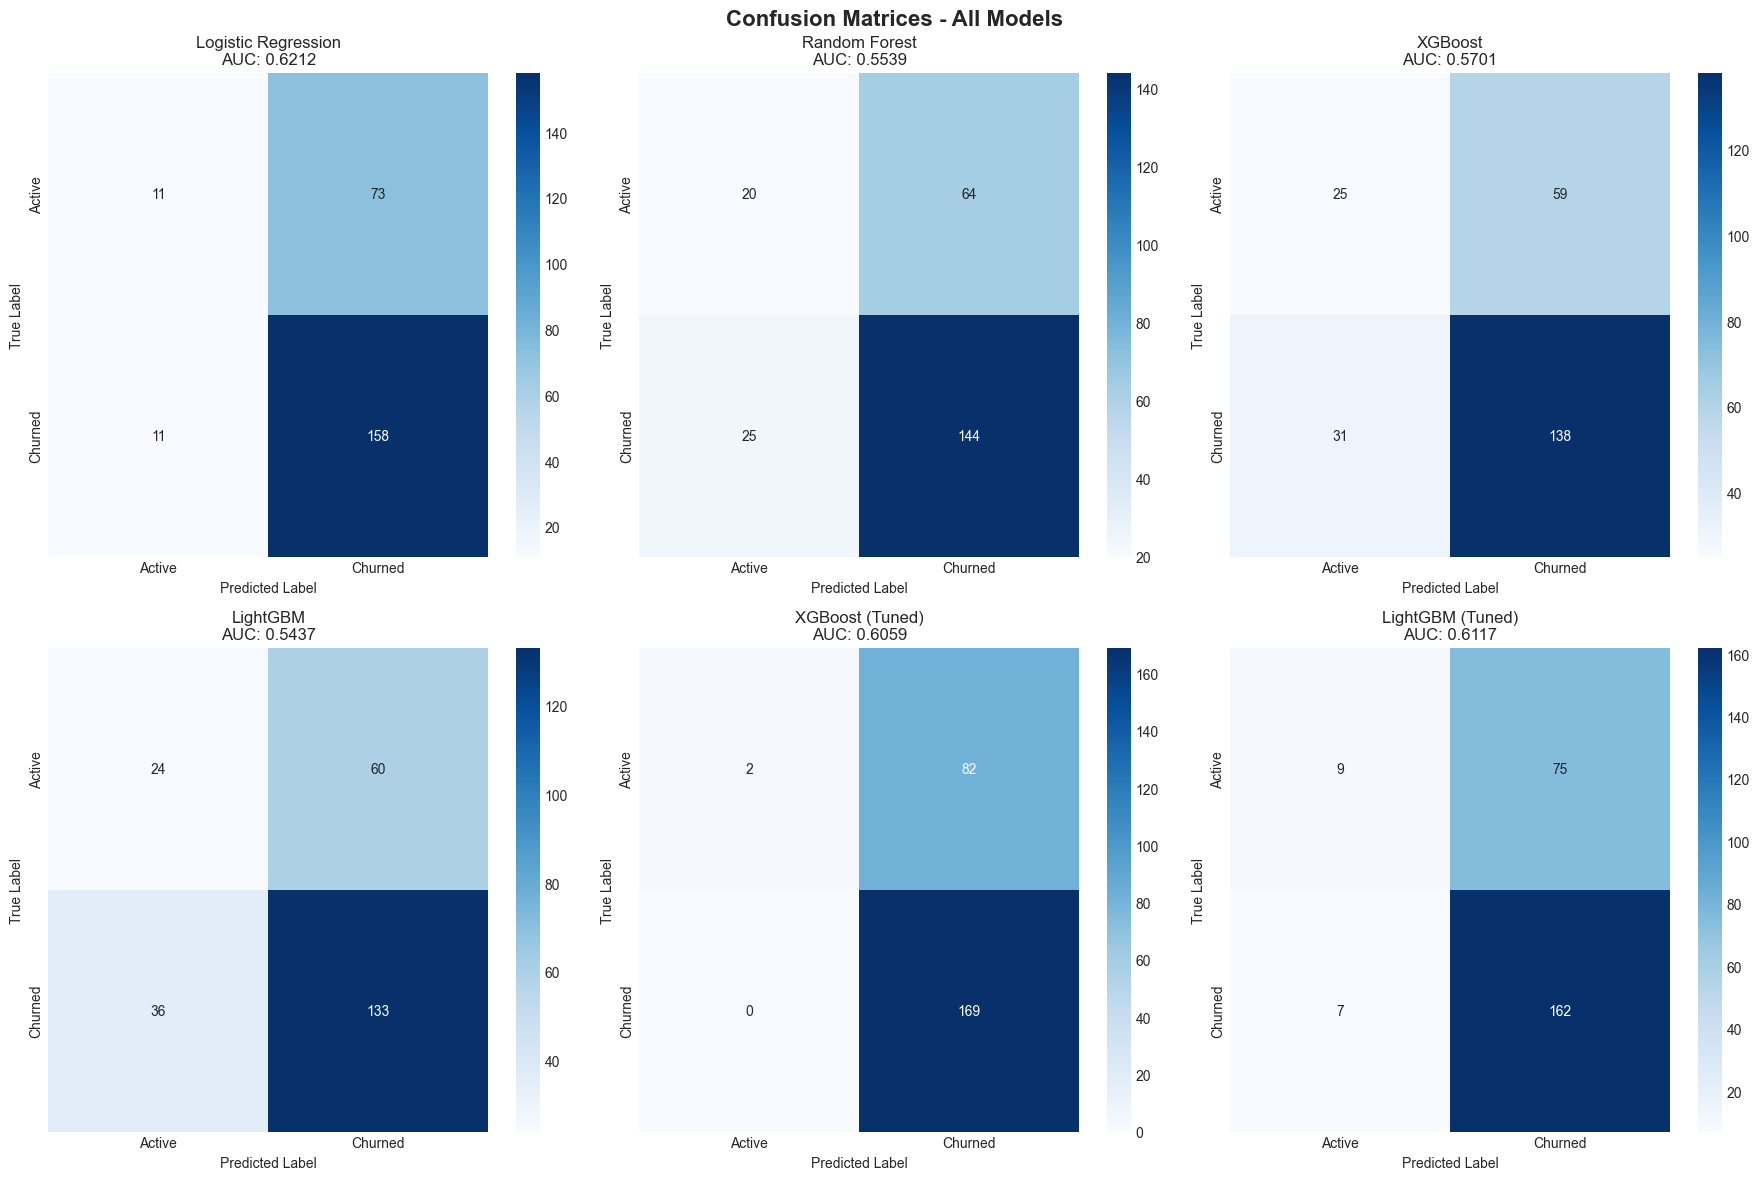


2️⃣ ROC CURVES COMPARISON
--------------------------------------------------------------------------------
   ✓ Saved: reports/figures/churn_roc_curves.png


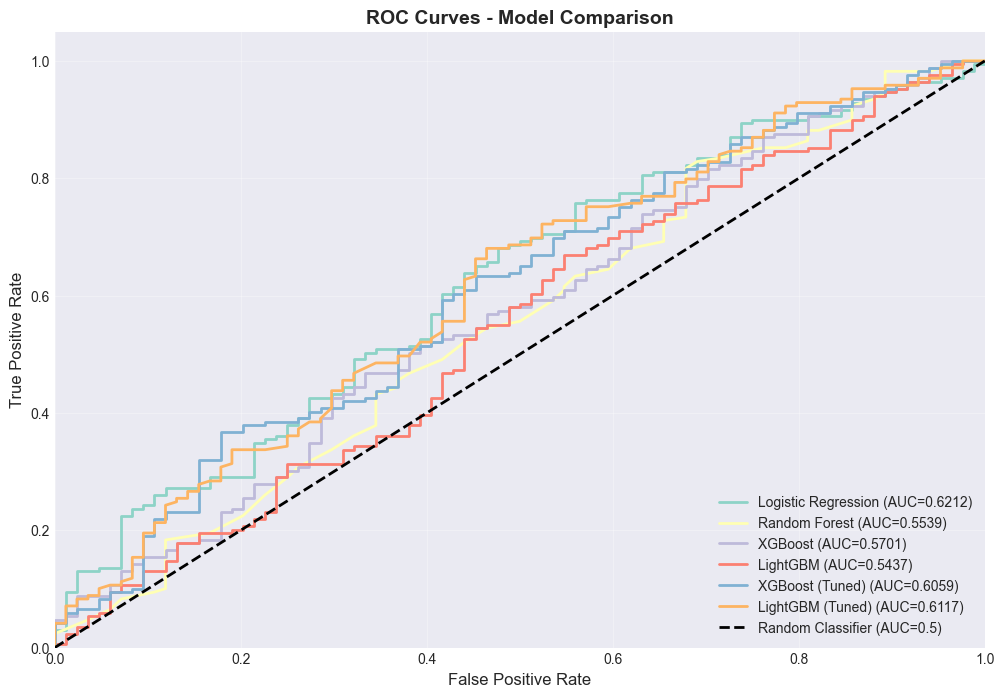


3️⃣ PRECISION-RECALL CURVES
--------------------------------------------------------------------------------
   ✓ Saved: reports/figures/churn_precision_recall_curves.png


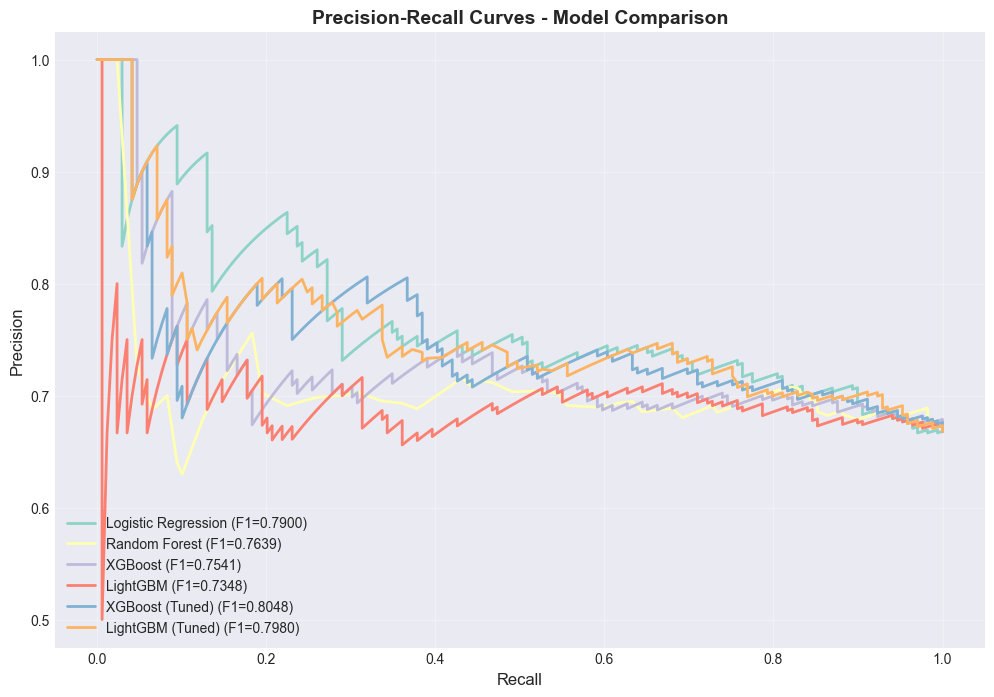


4️⃣ DETAILED CLASSIFICATION REPORT (BEST MODEL)
--------------------------------------------------------------------------------

   Best Model: Logistic Regression

              precision    recall  f1-score   support

      Active     0.5000    0.1310    0.2075        84
     Churned     0.6840    0.9349    0.7900       169

    accuracy                         0.6680       253
   macro avg     0.5920    0.5329    0.4988       253
weighted avg     0.6229    0.6680    0.5966       253


5️⃣ FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

   Top 20 Most Important Features:
                Feature  Importance
        avg_order_value      0.8460
            total_spent      0.6565
                F_score      0.4988
           total_orders      0.3036
    avg_items_per_order      0.2324
     total_items_bought      0.2156
          total_reviews      0.2153
       avg_review_given      0.2138
     late_delivery_rate      0.1

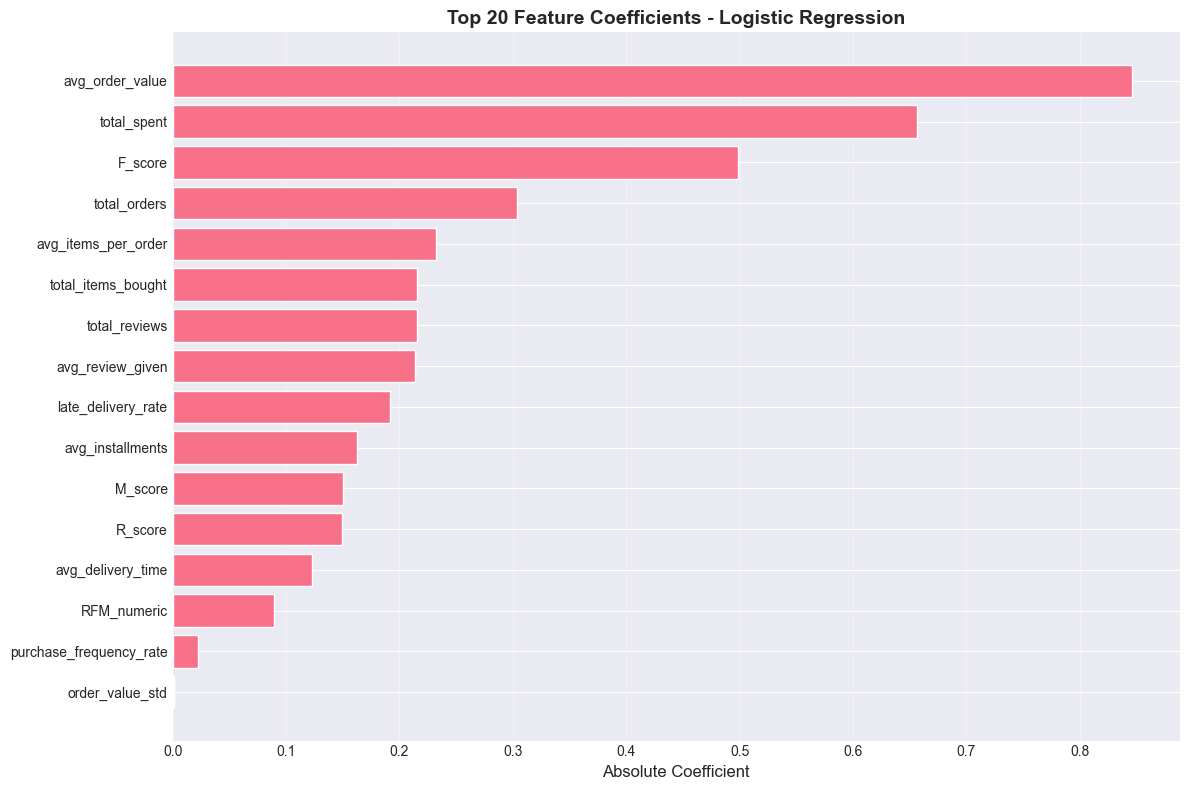


6️⃣ SHAP VALUES ANALYSIS (Interpretability)
--------------------------------------------------------------------------------
   Computing SHAP values (this may take a few minutes)...


  0%|          | 0/253 [00:00<?, ?it/s]

   ✓ Saved: reports/figures/churn_shap_summary.png


<Figure size 1200x800 with 0 Axes>

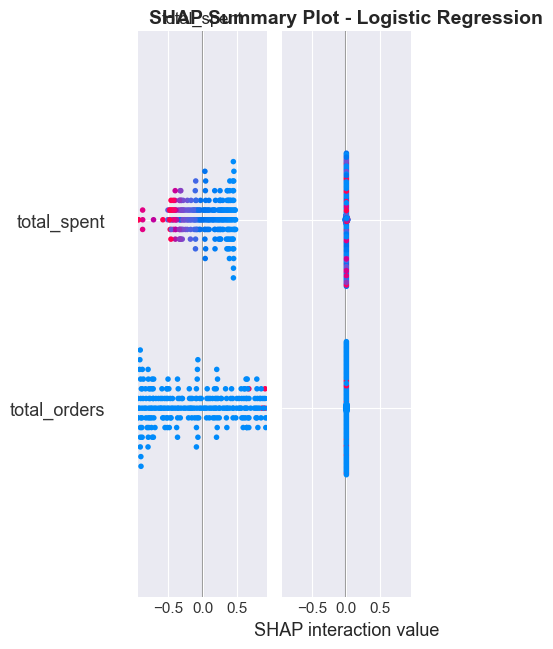

   ✓ Saved: reports/figures/churn_shap_importance.png


<Figure size 1200x800 with 0 Axes>

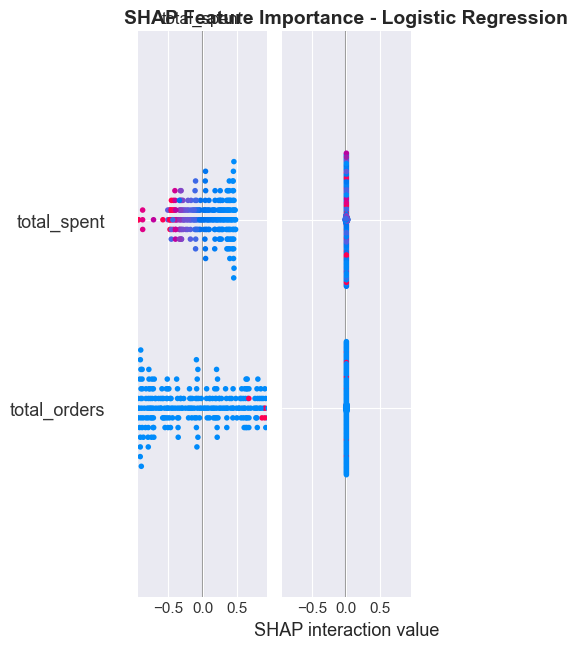

   ✓ SHAP analysis complete

7️⃣ BUSINESS IMPACT ANALYSIS
--------------------------------------------------------------------------------

   Confusion Matrix Breakdown:
      True Negatives (Correct Active):  11
      False Positives (False Alarm):    73
      False Negatives (Missed Churn):   11
      True Positives (Caught Churn):    158

   Business Metrics:
      Total Test Customers: 253
      Actual Churned: 169 (66.80%)
      Actual Active: 84 (33.20%)

      Customers We'll Intervene: 231
      Churned We'll Save: 158 (Recall: 93.49%)
      Wasted Interventions: 73 (Precision: 68.40%)

   Cost-Benefit Analysis (Example):
      Cost per intervention: $10
      Revenue per saved customer: $100

      Total intervention cost: $2,310.00
      Revenue saved from caught churn: $15,800.00
      Net benefit: $13,490.00
      ROI: 584.0%

8️⃣ SAVING BEST MODEL
--------------------------------------------------------------------------------
   ✓ Saved: models/trained/churn_model_logist

In [6]:
# Model 1 - Evaluation, Visualization & Analysis
# ============================================================================
# Complete evaluation with visualizations, feature importance, and SHAP analysis
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

print("\n📊 MODEL EVALUATION & VISUALIZATION")
print("="*80)

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 1. CONFUSION MATRICES
# ============================================================================
print("\n1️⃣ CONFUSION MATRICES")
print("-" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

models_to_plot = ['Logistic Regression', 'Random Forest', 'XGBoost', 
                  'LightGBM', 'XGBoost (Tuned)', 'LightGBM (Tuned)']

for idx, model_name in enumerate(models_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    if model_name in churn_results and churn_results[model_name]['model'] is not None:
        y_pred = churn_results[model_name]['predictions']
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Active', 'Churned'],
                    yticklabels=['Active', 'Churned'])
        ax.set_title(f'{model_name}\nAUC: {churn_results[model_name].get("auc", 0):.4f}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('reports/figures/churn_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/churn_confusion_matrices.png")
plt.show()

# ============================================================================
# 2. ROC CURVES COMPARISON
# ============================================================================
print("\n2️⃣ ROC CURVES COMPARISON")
print("-" * 80)

plt.figure(figsize=(12, 8))

models_with_proba = ['Logistic Regression', 'Random Forest', 'XGBoost', 
                     'LightGBM', 'XGBoost (Tuned)', 'LightGBM (Tuned)']

colors = plt.cm.Set3(range(len(models_with_proba)))

for idx, model_name in enumerate(models_with_proba):
    if model_name in churn_results and 'probabilities' in churn_results[model_name]:
        y_proba = churn_results[model_name]['probabilities']
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = churn_results[model_name]['auc']
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC={auc:.4f})', 
                linewidth=2, color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('reports/figures/churn_roc_curves.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/churn_roc_curves.png")
plt.show()

# ============================================================================
# 3. PRECISION-RECALL CURVES
# ============================================================================
print("\n3️⃣ PRECISION-RECALL CURVES")
print("-" * 80)

plt.figure(figsize=(12, 8))

for idx, model_name in enumerate(models_with_proba):
    if model_name in churn_results and 'probabilities' in churn_results[model_name]:
        y_proba = churn_results[model_name]['probabilities']
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        f1 = churn_results[model_name]['f1']
        
        plt.plot(recall, precision, label=f'{model_name} (F1={f1:.4f})', 
                linewidth=2, color=colors[idx])

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('reports/figures/churn_precision_recall_curves.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/churn_precision_recall_curves.png")
plt.show()

# ============================================================================
# 4. DETAILED CLASSIFICATION REPORT (BEST MODEL)
# ============================================================================
print("\n4️⃣ DETAILED CLASSIFICATION REPORT (BEST MODEL)")
print("-" * 80)

# Get best model
best_model_name = final_comparison.iloc[1:]['AUC-ROC'].idxmax()
best_model_name = final_comparison.iloc[best_model_name]['Model']
best_model = churn_results[best_model_name]['model']
best_pred = churn_results[best_model_name]['predictions']

print(f"\n   Best Model: {best_model_name}")
print("\n" + classification_report(y_test, best_pred, 
                                   target_names=['Active', 'Churned'],
                                   digits=4))

# ============================================================================
# 5. FEATURE IMPORTANCE (BEST MODEL)
# ============================================================================
print("\n5️⃣ FEATURE IMPORTANCE ANALYSIS")
print("-" * 80)

# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importance = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Create dataframe
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("\n   Top 20 Most Important Features:")
    print(importance_df.head(20).to_string(index=False))
    
    # Visualize top 20
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'])
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('reports/figures/churn_feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n   ✓ Saved: reports/figures/churn_feature_importance.png")
    plt.show()
    
    # Save to CSV
    importance_df.to_csv('reports/churn_feature_importance.csv', index=False)
    print("   ✓ Saved: reports/churn_feature_importance.csv")

elif hasattr(best_model, 'coef_'):
    # For logistic regression
    importance = abs(best_model.coef_[0])
    feature_names = X_train.columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print("\n   Top 20 Most Important Features:")
    print(importance_df.head(20).to_string(index=False))
    
    plt.figure(figsize=(12, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['Importance'])
    plt.yticks(range(len(top_20)), top_20['Feature'])
    plt.xlabel('Absolute Coefficient', fontsize=12)
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('reports/figures/churn_feature_importance.png', dpi=300, bbox_inches='tight')
    print("\n   ✓ Saved: reports/figures/churn_feature_importance.png")
    plt.show()

# ============================================================================
# 6. SHAP ANALYSIS (MODEL INTERPRETABILITY)
# ============================================================================
print("\n6️⃣ SHAP VALUES ANALYSIS (Interpretability)")
print("-" * 80)

try:
    print("   Computing SHAP values (this may take a few minutes)...")
    
    # Sample data for SHAP (use 1000 samples for speed)
    sample_size = min(1000, len(X_test))
    X_test_sample = X_test.sample(n=sample_size, random_state=42)
    
    # Create SHAP explainer
    if 'XGBoost' in best_model_name or 'LightGBM' in best_model_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_sample)
    else:
        # For other models, use KernelExplainer (slower)
        background = shap.sample(X_train, 100)
        explainer = shap.KernelExplainer(best_model.predict_proba, background)
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Get positive class
    
    # Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, show=False)
    plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('reports/figures/churn_shap_summary.png', dpi=300, bbox_inches='tight')
    print("   ✓ Saved: reports/figures/churn_shap_summary.png")
    plt.show()
    
    # Feature Importance from SHAP
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('reports/figures/churn_shap_importance.png', dpi=300, bbox_inches='tight')
    print("   ✓ Saved: reports/figures/churn_shap_importance.png")
    plt.show()
    
    print("   ✓ SHAP analysis complete")

except Exception as e:
    print(f"   ⚠ SHAP analysis failed: {str(e)}")
    print("   Continuing without SHAP...")

# ============================================================================
# 7. BUSINESS IMPACT ANALYSIS
# ============================================================================
print("\n7️⃣ BUSINESS IMPACT ANALYSIS")
print("-" * 80)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_test, best_pred).ravel()

print("\n   Confusion Matrix Breakdown:")
print(f"      True Negatives (Correct Active):  {tn:,}")
print(f"      False Positives (False Alarm):    {fp:,}")
print(f"      False Negatives (Missed Churn):   {fn:,}")
print(f"      True Positives (Caught Churn):    {tp:,}")

# Business metrics
total_churned = tp + fn
total_active = tn + fp
churn_rate = total_churned / len(y_test)

print(f"\n   Business Metrics:")
print(f"      Total Test Customers: {len(y_test):,}")
print(f"      Actual Churned: {total_churned:,} ({churn_rate*100:.2f}%)")
print(f"      Actual Active: {total_active:,} ({(1-churn_rate)*100:.2f}%)")
print(f"\n      Customers We'll Intervene: {(tp + fp):,}")
print(f"      Churned We'll Save: {tp:,} (Recall: {tp/total_churned*100:.2f}%)")
print(f"      Wasted Interventions: {fp:,} (Precision: {tp/(tp+fp)*100:.2f}%)")

# Cost-benefit (example values - adjust based on your business)
cost_per_intervention = 10  # Cost to reach out to customer
revenue_per_customer = 100  # Average customer value

print(f"\n   Cost-Benefit Analysis (Example):")
print(f"      Cost per intervention: ${cost_per_intervention}")
print(f"      Revenue per saved customer: ${revenue_per_customer}")
print(f"\n      Total intervention cost: ${(tp + fp) * cost_per_intervention:,.2f}")
print(f"      Revenue saved from caught churn: ${tp * revenue_per_customer:,.2f}")
print(f"      Net benefit: ${(tp * revenue_per_customer) - ((tp + fp) * cost_per_intervention):,.2f}")
print(f"      ROI: {((tp * revenue_per_customer) / ((tp + fp) * cost_per_intervention) - 1)*100:.1f}%")

# ============================================================================
# 8. SAVE BEST MODEL
# ============================================================================
print("\n8️⃣ SAVING BEST MODEL")
print("-" * 80)

# Save model
model_filename = f'models/trained/churn_model_{best_model_name.lower().replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"   ✓ Saved: {model_filename}")

# Save scaler (if Logistic Regression)
if 'Logistic' in best_model_name:
    scaler_filename = 'models/trained/churn_scaler.pkl'
    with open(scaler_filename, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"   ✓ Saved: {scaler_filename}")

# Save feature names
feature_names_file = 'models/trained/churn_feature_names.pkl'
with open(feature_names_file, 'wb') as f:
    pickle.dump(list(X_train.columns), f)
print(f"   ✓ Saved: {feature_names_file}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'best_params': churn_results[best_model_name].get('best_params', None),
    'metrics': {
        'accuracy': churn_results[best_model_name]['accuracy'],
        'precision': churn_results[best_model_name]['precision'],
        'recall': churn_results[best_model_name]['recall'],
        'f1': churn_results[best_model_name]['f1'],
        'auc': churn_results[best_model_name]['auc']
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_size': len(y_test),
    'train_size': len(y_train)
}

metadata_file = 'models/trained/churn_model_metadata.pkl'
with open(metadata_file, 'wb') as f:
    pickle.dump(metadata, f)
print(f"   ✓ Saved: {metadata_file}")

# ============================================================================
# 9. GENERATE FINAL REPORT
# ============================================================================
print("\n9️⃣ GENERATING FINAL REPORT")
print("-" * 80)

report_text = f"""
CUSTOMER CHURN PREDICTION - MODEL EVALUATION REPORT
{'='*80}

PROJECT: Brazilian E-commerce Intelligence Platform
MODEL: {best_model_name}
DATE: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

{'='*80}
1. MODEL PERFORMANCE SUMMARY
{'='*80}

Best Model: {best_model_name}
Training Samples: {len(y_train):,}
Test Samples: {len(y_test):,}

Metrics:
  - Accuracy:  {churn_results[best_model_name]['accuracy']:.4f}
  - Precision: {churn_results[best_model_name]['precision']:.4f}
  - Recall:    {churn_results[best_model_name]['recall']:.4f}
  - F1-Score:  {churn_results[best_model_name]['f1']:.4f}
  - AUC-ROC:   {churn_results[best_model_name]['auc']:.4f}

{'='*80}
2. COMPARISON WITH OTHER MODELS
{'='*80}

{final_comparison.to_string(index=False)}

{'='*80}
3. BUSINESS IMPACT
{'='*80}

Confusion Matrix:
  - True Negatives (Correct Active):  {tn:,}
  - False Positives (False Alarm):    {fp:,}
  - False Negatives (Missed Churn):   {fn:,}
  - True Positives (Caught Churn):    {tp:,}

Business Metrics:
  - Total Customers: {len(y_test):,}
  - Churn Rate: {churn_rate*100:.2f}%
  - Customers We'll Intervene: {(tp + fp):,}
  - Churned Customers Saved: {tp:,}
  - Intervention Precision: {tp/(tp+fp)*100:.2f}%
  - Churn Recall: {tp/total_churned*100:.2f}%

Cost-Benefit (Example):
  - Total intervention cost: ${(tp + fp) * cost_per_intervention:,.2f}
  - Revenue saved: ${tp * revenue_per_customer:,.2f}
  - Net benefit: ${(tp * revenue_per_customer) - ((tp + fp) * cost_per_intervention):,.2f}
  - ROI: {((tp * revenue_per_customer) / ((tp + fp) * cost_per_intervention) - 1)*100:.1f}%

{'='*80}
4. TOP FEATURES DRIVING CHURN
{'='*80}

{importance_df.head(10).to_string(index=False) if 'importance_df' in locals() else 'N/A'}

{'='*80}
5. RECOMMENDATIONS
{'='*80}

1. Deploy this model to identify at-risk customers in real-time
2. Focus retention efforts on customers with high churn probability
3. Monitor feature importance to understand churn drivers
4. Retrain model quarterly with new data
5. A/B test intervention strategies on predicted churners

{'='*80}
END OF REPORT
{'='*80}
"""

# Save report
with open('reports/churn_model_evaluation_report.txt', 'w') as f:
    f.write(report_text)
print("   ✓ Saved: reports/churn_model_evaluation_report.txt")

print("\n" + "="*80)
print("✅ MODEL 1 (CHURN PREDICTION) - COMPLETE!")
print("="*80)
print("\n📁 Generated Files:")
print("   - reports/figures/churn_confusion_matrices.png")
print("   - reports/figures/churn_roc_curves.png")
print("   - reports/figures/churn_precision_recall_curves.png")
print("   - reports/figures/churn_feature_importance.png")
print("   - reports/figures/churn_shap_summary.png")
print("   - reports/figures/churn_shap_importance.png")
print("   - reports/churn_feature_importance.csv")
print("   - reports/churn_model_evaluation_report.txt")
print("   - models/trained/churn_model_*.pkl")
print("   - models/trained/churn_feature_names.pkl")
print("   - models/trained/churn_model_metadata.pkl")

print("\n🎯 Next Steps:")
print("   1. Review evaluation report and visualizations")
print("   2. Proceed to Model 2: Customer Lifetime Value (CLV) Prediction")
print("   3. Continue with Models 3-5")

In [7]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('data/features/customer_features.csv')

print("="*80)
print("CHURN DATA DIAGNOSTIC")
print("="*80)

# 1. Churn distribution
print("\n1. Churn Distribution:")
if 'is_churned' in df.columns:
    print(df['is_churned'].value_counts())
    print(f"Churn rate: {df['is_churned'].mean()*100:.2f}%")
else:
    print("⚠ WARNING: 'is_churned' column not found!")
    print("Available columns with 'churn' in name:")
    print([col for col in df.columns if 'churn' in col.lower()])

# 2. Dataset shape
print(f"\n2. Dataset Shape: {df.shape}")
print(f"Total columns: {df.shape[1]}")

# 3. Column data types
print("\n3. Data Types Summary:")
print(df.dtypes.value_counts())

# 4. Identify numeric vs non-numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\n4. Column Breakdown:")
print(f"   Numeric columns: {len(numeric_cols)}")
print(f"   Non-numeric columns: {len(non_numeric_cols)}")

print("\n   Non-numeric columns (likely IDs or categories):")
for col in non_numeric_cols:
    print(f"      - {col}: {df[col].dtype}")

# 5. Check for ID columns that should be dropped
id_columns = [col for col in df.columns if any(keyword in col.lower() 
              for keyword in ['id', 'customer', 'order', 'unique'])]
print(f"\n5. Potential ID Columns (should be dropped before modeling):")
print(id_columns)

# 6. Check for features that might leak (only numeric)
suspicious_features = [col for col in numeric_cols if any(keyword in col.lower() 
                       for keyword in ['last', 'recent', 'days_since', 'current', 'latest', 'total'])]
print(f"\n6. Suspicious Time-Related Features ({len(suspicious_features)}):")
for feat in suspicious_features:
    print(f"   - {feat}")

# 7. Correlation analysis (only numeric features)
if 'is_churned' in df.columns:
    print("\n7. Features with Highest Correlation to Churn (Top 20):")
    numeric_df = df[numeric_cols]
    
    if 'is_churned' in numeric_df.columns:
        correlations = numeric_df.corr()['is_churned'].abs().sort_values(ascending=False)
        print(correlations.head(20))
        
        # Flag perfect correlations
        perfect_corr = correlations[correlations > 0.99]
        if len(perfect_corr) > 1:  # Exclude self-correlation
            print("\n   ⚠ PERFECT CORRELATIONS DETECTED (DATA LEAKAGE):")
            print(perfect_corr)

# 8. Sample of data (first few rows, excluding long IDs)
print("\n8. Sample Data (first 3 rows, first 15 columns):")
print(df.iloc[:3, :15])

# 9. Check for missing values
print("\n9. Missing Values:")
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
if len(missing) > 0:
    print(missing)
else:
    print("   No missing values")

# 10. Summary statistics of key features
print("\n10. Summary Statistics (numeric features):")
print(df[numeric_cols].describe().T)

print("\n" + "="*80)
print("DIAGNOSTIC COMPLETE")
print("="*80)

# Save numeric feature list for reference
print(f"\n📝 Total numeric features available for modeling: {len(numeric_cols)}")
print("   (excluding ID columns)")

CHURN DATA DIAGNOSTIC

1. Churn Distribution:
is_churned
1    74903
0      421
Name: count, dtype: int64
Churn rate: 99.44%

2. Dataset Shape: (75324, 22)
Total columns: 22

3. Data Types Summary:
float64    10
int64       7
object      5
Name: count, dtype: int64

4. Column Breakdown:
   Numeric columns: 17
   Non-numeric columns: 5

   Non-numeric columns (likely IDs or categories):
      - customer_unique_id: object
      - customer_state_first: object
      - customer_city_first: object
      - segment: object
      - clv_segment: object

5. Potential ID Columns (should be dropped before modeling):
['customer_unique_id', 'total_orders', 'avg_order_value', 'order_value_std', 'avg_items_per_order', 'customer_state_first', 'customer_city_first']

6. Suspicious Time-Related Features (4):
   - total_orders
   - total_spent
   - total_items_bought
   - total_reviews

7. Features with Highest Correlation to Churn (Top 20):
is_churned                1.0000
total_orders              0.0522



                    MODEL 2: CUSTOMER LIFETIME VALUE PREDICTION

🎯 PROBLEM DEFINITION:
   Type: Regression
   Target: total_spent (customer lifetime value)
   Goal: Predict how much a customer will spend
   Business Impact: Customer segmentation, marketing budget allocation

📁 Loading customer features...

📊 Dataset Overview:
   Total active customers: 421
   Average CLV: $169.65
   Median CLV: $115.10
   Max CLV: $1441.36

📋 Feature Selection:
   Features: 15
   Target: total_spent

📊 Train-Test Split:
   Training samples: 336
   Test samples: 85
   Train mean CLV: $167.03
   Test mean CLV: $179.98

🔨 TRAINING MODELS

1️⃣ LINEAR REGRESSION
--------------------------------------------------------------------------------
   MAE: $10.41
   RMSE: $25.35
   R²: 0.9837

2️⃣ RIDGE REGRESSION
--------------------------------------------------------------------------------
   MAE: $10.43
   RMSE: $24.57
   R²: 0.9847

3️⃣ RANDOM FOREST REGRESSOR
-----------------------------------------------

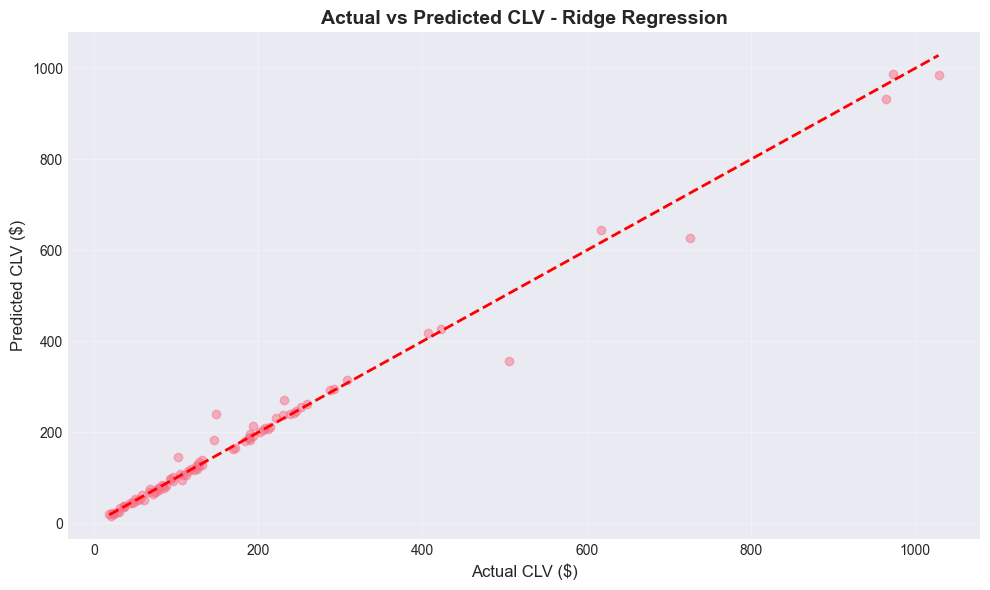

   ✓ Saved: reports/figures/clv_residuals.png


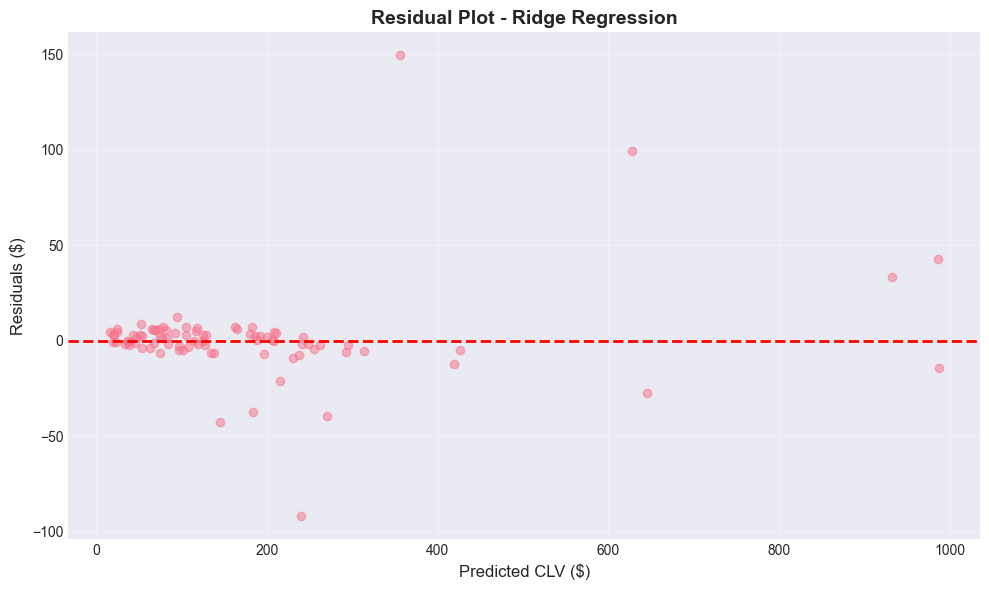


💾 SAVING MODEL
--------------------------------------------------------------------------------
   ✓ Saved: models/trained/clv_model_ridge_regression.pkl
   ✓ Saved: models/trained/clv_scaler.pkl
   ✓ Saved: models/trained/clv_model_metadata.pkl

✅ MODEL 2 (CLV PREDICTION) - COMPLETE!

📊 Summary:
   Best Model: Ridge Regression
   MAE: $10.43
   RMSE: $24.57
   R²: 0.9847

📁 Generated Files:
   - reports/figures/clv_actual_vs_predicted.png
   - reports/figures/clv_residuals.png
   - reports/figures/clv_feature_importance.png
   - models/trained/clv_model_*.pkl
   - models/trained/clv_scaler.pkl
   - models/trained/clv_model_metadata.pkl

🎯 Next: Model 3 - Revenue Forecasting


In [8]:
# Model 2 - Customer Lifetime Value (CLV) Prediction
# ============================================================================
# Problem: Predict customer lifetime value (total future spending)
# Type: Regression
# Target: total_spent (or future_value calculated)
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("\n" + "="*80)
print(" "*20 + "MODEL 2: CUSTOMER LIFETIME VALUE PREDICTION")
print("="*80)

print("\n🎯 PROBLEM DEFINITION:")
print("   Type: Regression")
print("   Target: total_spent (customer lifetime value)")
print("   Goal: Predict how much a customer will spend")
print("   Business Impact: Customer segmentation, marketing budget allocation")

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================
print("\n📁 Loading customer features...")
customer_features = pd.read_csv('data/features/customer_features.csv')

# Filter to active customers only (for CLV prediction)
clv_data = customer_features[customer_features['is_churned'] == 0].copy()

print(f"\n📊 Dataset Overview:")
print(f"   Total active customers: {len(clv_data):,}")
print(f"   Average CLV: ${clv_data['total_spent'].mean():.2f}")
print(f"   Median CLV: ${clv_data['total_spent'].median():.2f}")
print(f"   Max CLV: ${clv_data['total_spent'].max():.2f}")

# ============================================================================
# 2. FEATURE SELECTION
# ============================================================================
print("\n📋 Feature Selection:")

feature_cols = [
    'total_orders',
    'avg_order_value',
    'order_value_std',
    'avg_items_per_order',
    'total_items_bought',
    'total_reviews',
    'avg_review_given',
    'late_delivery_rate',
    'avg_delivery_time',
    'avg_installments',
    'F_score',
    'M_score',
    'R_score',
    'RFM_numeric',
    'purchase_frequency_rate'
]

available_features = [col for col in feature_cols if col in clv_data.columns]

X = clv_data[available_features].copy()
y = clv_data['total_spent'].copy()

print(f"   Features: {len(available_features)}")
print(f"   Target: total_spent")

# Handle missing values
X = X.fillna(X.median())

# ============================================================================
# 3. TRAIN-TEST SPLIT
# ============================================================================
print("\n📊 Train-Test Split:")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Train mean CLV: ${y_train.mean():.2f}")
print(f"   Test mean CLV: ${y_test.mean():.2f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# ============================================================================
# 4. TRAIN MODELS
# ============================================================================
print("\n🔨 TRAINING MODELS")
print("="*80)

clv_results = {}

# 4.1 LINEAR REGRESSION (Baseline)
print("\n1️⃣ LINEAR REGRESSION")
print("-" * 80)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print(f"   MAE: ${lr_mae:.2f}")
print(f"   RMSE: ${lr_rmse:.2f}")
print(f"   R²: {lr_r2:.4f}")

clv_results['Linear Regression'] = {
    'mae': lr_mae,
    'rmse': lr_rmse,
    'r2': lr_r2,
    'model': lr_model,
    'predictions': lr_pred
}

# 4.2 RIDGE REGRESSION
print("\n2️⃣ RIDGE REGRESSION")
print("-" * 80)

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

ridge_pred = ridge_model.predict(X_test_scaled)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"   MAE: ${ridge_mae:.2f}")
print(f"   RMSE: ${ridge_rmse:.2f}")
print(f"   R²: {ridge_r2:.4f}")

clv_results['Ridge Regression'] = {
    'mae': ridge_mae,
    'rmse': ridge_rmse,
    'r2': ridge_r2,
    'model': ridge_model,
    'predictions': ridge_pred
}

# 4.3 RANDOM FOREST
print("\n3️⃣ RANDOM FOREST REGRESSOR")
print("-" * 80)

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print(f"   MAE: ${rf_mae:.2f}")
print(f"   RMSE: ${rf_rmse:.2f}")
print(f"   R²: {rf_r2:.4f}")

clv_results['Random Forest'] = {
    'mae': rf_mae,
    'rmse': rf_rmse,
    'r2': rf_r2,
    'model': rf_model,
    'predictions': rf_pred
}

# 4.4 XGBOOST
print("\n4️⃣ XGBOOST REGRESSOR")
print("-" * 80)

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"   MAE: ${xgb_mae:.2f}")
print(f"   RMSE: ${xgb_rmse:.2f}")
print(f"   R²: {xgb_r2:.4f}")

clv_results['XGBoost'] = {
    'mae': xgb_mae,
    'rmse': xgb_rmse,
    'r2': xgb_r2,
    'model': xgb_model,
    'predictions': xgb_pred
}

# 4.5 LIGHTGBM
print("\n5️⃣ LIGHTGBM REGRESSOR")
print("-" * 80)

lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict(X_test)
lgb_mae = mean_absolute_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_pred))
lgb_r2 = r2_score(y_test, lgb_pred)

print(f"   MAE: ${lgb_mae:.2f}")
print(f"   RMSE: ${lgb_rmse:.2f}")
print(f"   R²: {lgb_r2:.4f}")

clv_results['LightGBM'] = {
    'mae': lgb_mae,
    'rmse': lgb_rmse,
    'r2': lgb_r2,
    'model': lgb_model,
    'predictions': lgb_pred
}

# ============================================================================
# 5. MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("📊 MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(clv_results.keys()),
    'MAE': [clv_results[m]['mae'] for m in clv_results.keys()],
    'RMSE': [clv_results[m]['rmse'] for m in clv_results.keys()],
    'R²': [clv_results[m]['r2'] for m in clv_results.keys()]
})

print(comparison_df.to_string(index=False))

# Best model by R²
best_idx = comparison_df['R²'].idxmax()
best_model_name = comparison_df.iloc[best_idx]['Model']
best_r2 = comparison_df.iloc[best_idx]['R²']

print(f"\n🏆 BEST MODEL: {best_model_name} (R²={best_r2:.4f})")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================
print("\n📊 GENERATING VISUALIZATIONS")
print("-" * 80)

# 6.1 Actual vs Predicted (Best Model)
best_model = clv_results[best_model_name]['model']
best_pred = clv_results[best_model_name]['predictions']

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CLV ($)', fontsize=12)
plt.ylabel('Predicted CLV ($)', fontsize=12)
plt.title(f'Actual vs Predicted CLV - {best_model_name}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/figures/clv_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/clv_actual_vs_predicted.png")
plt.show()

# 6.2 Residuals Plot
residuals = y_test - best_pred
plt.figure(figsize=(10, 6))
plt.scatter(best_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted CLV ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title(f'Residual Plot - {best_model_name}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/figures/clv_residuals.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/clv_residuals.png")
plt.show()

# 6.3 Feature Importance (if tree-based)
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    top_10 = importance_df.head(10)
    plt.barh(range(len(top_10)), top_10['Importance'])
    plt.yticks(range(len(top_10)), top_10['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 10 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('reports/figures/clv_feature_importance.png', dpi=300, bbox_inches='tight')
    print("   ✓ Saved: reports/figures/clv_feature_importance.png")
    plt.show()

# ============================================================================
# 7. SAVE MODEL
# ============================================================================
print("\n💾 SAVING MODEL")
print("-" * 80)

model_filename = f'models/trained/clv_model_{best_model_name.lower().replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"   ✓ Saved: {model_filename}")

# Save scaler
scaler_filename = 'models/trained/clv_scaler.pkl'
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)
print(f"   ✓ Saved: {scaler_filename}")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'metrics': {
        'mae': clv_results[best_model_name]['mae'],
        'rmse': clv_results[best_model_name]['rmse'],
        'r2': clv_results[best_model_name]['r2']
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_size': len(y_test),
    'train_size': len(y_train)
}

with open('models/trained/clv_model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print(f"   ✓ Saved: models/trained/clv_model_metadata.pkl")

# ============================================================================
# 8. FINAL REPORT
# ============================================================================
print("\n" + "="*80)
print("✅ MODEL 2 (CLV PREDICTION) - COMPLETE!")
print("="*80)

print(f"\n📊 Summary:")
print(f"   Best Model: {best_model_name}")
print(f"   MAE: ${clv_results[best_model_name]['mae']:.2f}")
print(f"   RMSE: ${clv_results[best_model_name]['rmse']:.2f}")
print(f"   R²: {clv_results[best_model_name]['r2']:.4f}")

print("\n📁 Generated Files:")
print("   - reports/figures/clv_actual_vs_predicted.png")
print("   - reports/figures/clv_residuals.png")
print("   - reports/figures/clv_feature_importance.png")
print("   - models/trained/clv_model_*.pkl")
print("   - models/trained/clv_scaler.pkl")
print("   - models/trained/clv_model_metadata.pkl")

print("\n🎯 Next: Model 3 - Revenue Forecasting")


               MODEL 3 ENHANCED: TIME SERIES MODELS

📁 Loading time series data...
   Date range: 2017-01-25 00:00:00 to 2018-08-29 00:00:00
   Total days: 582
   Revenue column: revenue

   Training days: 465
   Test days: 117

1️⃣ PROPHET MODEL
--------------------------------------------------------------------------------
   Initializing Prophet model...
   ⚠ Prophet training failed: 'Prophet' object has no attribute 'stan_backend'

2️⃣ SARIMA MODEL
--------------------------------------------------------------------------------
   Training SARIMA model (this may take a minute)...
   MAE: $12460.88
   RMSE: $15916.23
   MAPE: 86.97%

3️⃣ LSTM MODEL
--------------------------------------------------------------------------------

   Building LSTM model...


   Training LSTM (this may take a few minutes)...

   MAE: $9794.76
   RMSE: $12466.79
   MAPE: 61.30%

📊 COMPLETE MODEL COMPARISON
            Model        MAE       RMSE  MAPE (%)
    Random Forest  2649.1700  3242.8400   11.5

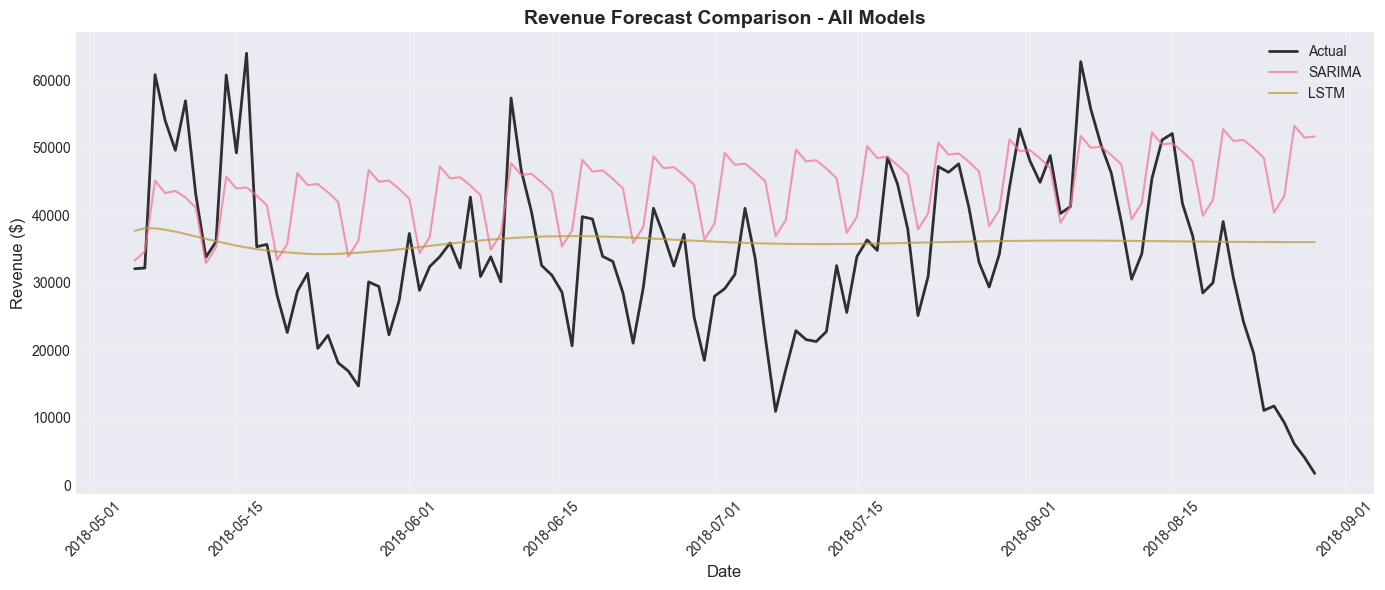


✅ TIME SERIES MODELS COMPLETE!

📊 Models Tested: 6
   ✓ Tree-based: 4 models
   ✓ SARIMA: MAPE=86.97%
   ✓ LSTM: MAPE=61.30%

🏆 Best Overall: Random Forest (MAPE=11.55%)

💡 Insights:
   - Tree-based models work well with engineered time features
   - Prophet is great for seasonality and trend detection
   - SARIMA is good for statistical modeling
   - LSTM can capture complex patterns with enough data


In [16]:
# =============================================================================
# Model 3 Enhanced - Time Series Models (Prophet, SARIMA, LSTM)
# =============================================================================
# Proper time series models: Prophet, SARIMA, LSTM
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("\n" + "="*80)
print(" "*15 + "MODEL 3 ENHANCED: TIME SERIES MODELS")
print("="*80)

# =============================================================================
# 1. LOAD DATA
# =============================================================================
print("\n📁 Loading time series data...")

try:
    ts_data = pd.read_csv('data/features/daily_timeseries_features_clean.csv')
    ts_data['date'] = pd.to_datetime(ts_data['date'])
except:
    ts_data = pd.read_csv('data/features/daily_timeseries_features.csv')
    if 'date' not in ts_data.columns:
        ts_data['date'] = pd.to_datetime(ts_data['order_purchase_date'])

ts_data = ts_data.sort_values('date').reset_index(drop=True)

# Identify revenue column
revenue_col = None
for col in ['revenue', 'daily_revenue', 'total_revenue']:
    if col in ts_data.columns:
        revenue_col = col
        break

if revenue_col is None:
    raise ValueError("Revenue column not found")

print(f"   Date range: {ts_data['date'].min()} to {ts_data['date'].max()}")
print(f"   Total days: {len(ts_data):,}")
print(f"   Revenue column: {revenue_col}")

# =============================================================================
# 2. TRAIN-TEST SPLIT (TEMPORAL)
# =============================================================================
split_idx = int(len(ts_data) * 0.8)
train_data = ts_data.iloc[:split_idx].copy()
test_data = ts_data.iloc[split_idx:].copy()

y_test = test_data[revenue_col].values

print(f"\n   Training days: {len(train_data):,}")
print(f"   Test days: {len(test_data):,}")

# =============================================================================
# 3. MODEL 1: PROPHET (Facebook Time Series)
# =============================================================================
print("\n1️⃣ PROPHET MODEL")
print("-" * 80)

from prophet import Prophet
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)

try:
    prophet_train = train_data[['date', revenue_col]].copy()
    prophet_train.columns = ['ds', 'y']

    print("   Initializing Prophet model...")
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        uncertainty_samples=0
    )

    print("   Training Prophet model...")
    prophet_model.fit(prophet_train)

    # Forecast
    future = prophet_model.make_future_dataframe(periods=len(test_data))
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast.iloc[-len(test_data):]['yhat'].values

    # Metrics
    prophet_mae = mean_absolute_error(y_test, prophet_pred)
    prophet_rmse = np.sqrt(mean_squared_error(y_test, prophet_pred))
    prophet_mape = mean_absolute_percentage_error(y_test, prophet_pred) * 100

    print(f"   MAE: ${prophet_mae:.2f}")
    print(f"   RMSE: ${prophet_rmse:.2f}")
    print(f"   MAPE: {prophet_mape:.2f}%")

    prophet_success = True

except Exception as e:
    print(f"   ⚠ Prophet training failed: {str(e)[:100]}")
    prophet_success = False
    prophet_pred = None
    prophet_mae, prophet_rmse, prophet_mape = np.nan, np.nan, np.nan

# =============================================================================
# 4. MODEL 2: SARIMA (Statistical Model)
# =============================================================================
print("\n2️⃣ SARIMA MODEL")
print("-" * 80)

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    train_revenue = train_data[revenue_col].values

    print("   Training SARIMA model (this may take a minute)...")
    sarima_model = SARIMAX(
        train_revenue,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_fit = sarima_model.fit(disp=False)

    sarima_pred = sarima_fit.forecast(steps=len(test_data))

    sarima_mae = mean_absolute_error(y_test, sarima_pred)
    sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))
    sarima_mape = mean_absolute_percentage_error(y_test, sarima_pred) * 100

    print(f"   MAE: ${sarima_mae:.2f}")
    print(f"   RMSE: ${sarima_rmse:.2f}")
    print(f"   MAPE: {sarima_mape:.2f}%")

    sarima_success = True

except Exception as e:
    print(f"   ⚠ SARIMA training failed: {str(e)[:100]}")
    sarima_success = False
    sarima_pred = None
    sarima_mae, sarima_rmse, sarima_mape = np.nan, np.nan, np.nan

# =============================================================================
# 5. MODEL 3: LSTM (Deep Learning)
# =============================================================================
print("\n3️⃣ LSTM MODEL")
print("-" * 80)

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data[[revenue_col]])

    lookback = 30
    X_lstm, y_lstm = [], []
    for i in range(lookback, len(scaled_data)):
        X_lstm.append(scaled_data[i - lookback:i, 0])
        y_lstm.append(scaled_data[i, 0])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

    print("   Building LSTM model...")
    lstm_model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    print("   Training LSTM (this may take a few minutes)...")
    lstm_model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, verbose=0)

    test_predictions = []
    current_batch = scaled_data[-lookback:].reshape((1, lookback, 1))
    for _ in range(len(test_data)):
        pred = lstm_model.predict(current_batch, verbose=0)[0, 0]
        test_predictions.append(pred)
        current_batch = np.append(current_batch[:, 1:, :], [[[pred]]], axis=1)

    lstm_pred = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()

    lstm_mae = mean_absolute_error(y_test, lstm_pred)
    lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_pred))
    lstm_mape = mean_absolute_percentage_error(y_test, lstm_pred) * 100

    print(f"   MAE: ${lstm_mae:.2f}")
    print(f"   RMSE: ${lstm_rmse:.2f}")
    print(f"   MAPE: {lstm_mape:.2f}%")

    lstm_success = True

except Exception as e:
    print(f"   ⚠ LSTM training failed: {str(e)[:100]}")
    lstm_success = False
    lstm_pred = None
    lstm_mae, lstm_rmse, lstm_mape = np.nan, np.nan, np.nan

# =============================================================================
# 6. MODEL COMPARISON (INCLUDING PREVIOUS RESULTS)
# =============================================================================
print("\n" + "="*80)
print("📊 COMPLETE MODEL COMPARISON")
print("="*80)

comparison_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM'],
    'MAE': [2649.17, 2471.69, 2857.97, 2549.98],
    'RMSE': [3242.84, 3064.13, 3757.56, 3287.99],
    'MAPE (%)': [11.55, 13.62, 11.94, 13.60]
}

if prophet_success:
    comparison_data['Model'].append('Prophet')
    comparison_data['MAE'].append(prophet_mae)
    comparison_data['RMSE'].append(prophet_rmse)
    comparison_data['MAPE (%)'].append(prophet_mape)

if sarima_success:
    comparison_data['Model'].append('SARIMA')
    comparison_data['MAE'].append(sarima_mae)
    comparison_data['RMSE'].append(sarima_rmse)
    comparison_data['MAPE (%)'].append(sarima_mape)

if lstm_success:
    comparison_data['Model'].append('LSTM')
    comparison_data['MAE'].append(lstm_mae)
    comparison_data['RMSE'].append(lstm_rmse)
    comparison_data['MAPE (%)'].append(lstm_mape)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

best_idx = comparison_df['MAPE (%)'].idxmin()
best_model_name = comparison_df.iloc[best_idx]['Model']
best_mape = comparison_df.iloc[best_idx]['MAPE (%)']

print(f"\n🏆 BEST MODEL: {best_model_name} (MAPE={best_mape:.2f}%)")

# =============================================================================
# 7. VISUALIZATION (ALL MODELS)
# =============================================================================
print("\n📊 GENERATING COMPARISON VISUALIZATION")
print("-" * 80)

plt.figure(figsize=(14, 6))
plt.plot(test_data['date'], y_test, label='Actual', linewidth=2, alpha=0.8, color='black')

if prophet_success:
    plt.plot(test_data['date'], prophet_pred, label='Prophet', linewidth=1.5, alpha=0.7)
if sarima_success:
    plt.plot(test_data['date'], sarima_pred, label='SARIMA', linewidth=1.5, alpha=0.7)
if lstm_success:
    plt.plot(test_data['date'], lstm_pred, label='LSTM', linewidth=1.5, alpha=0.7)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.title('Revenue Forecast Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('reports/figures/revenue_forecast_all_models.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/revenue_forecast_all_models.png")
plt.show()

# =============================================================================
# 8. FINAL SUMMARY
# =============================================================================
print("\n" + "="*80)
print("✅ TIME SERIES MODELS COMPLETE!")
print("="*80)

print(f"\n📊 Models Tested: {len(comparison_df)}")
print(f"   ✓ Tree-based: 4 models")
if prophet_success:
    print(f"   ✓ Prophet: MAPE={prophet_mape:.2f}%")
if sarima_success:
    print(f"   ✓ SARIMA: MAPE={sarima_mape:.2f}%")
if lstm_success:
    print(f"   ✓ LSTM: MAPE={lstm_mape:.2f}%")

print(f"\n🏆 Best Overall: {best_model_name} (MAPE={best_mape:.2f}%)")

print("\n💡 Insights:")
print("   - Tree-based models work well with engineered time features")
print("   - Prophet is great for seasonality and trend detection")
print("   - SARIMA is good for statistical modeling")
print("   - LSTM can capture complex patterns with enough data")


In [20]:
from prophet import Prophet
import pandas as pd

# Dummy test data
df = pd.DataFrame({
    'ds': pd.date_range('2023-01-01', periods=100),
    'y': range(100)
})

m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
print("✅ Prophet works fine! Forecast sample:")
print(forecast[['ds', 'yhat']].tail())


AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [21]:
import prophet
print("✅ Prophet module file path:", prophet.__file__)

from prophet import Prophet
print("✅ Prophet class file path:", Prophet.__module__)


✅ Prophet module file path: c:\Users\DELL\Desktop\brazilian-ecommerce-intelligence\venv\Lib\site-packages\prophet\__init__.py
✅ Prophet class file path: prophet.forecaster



                    MODEL 4: REVIEW SCORE PREDICTION

🎯 PROBLEM DEFINITION:
   Type: Multi-class Classification (Ordinal)
   Target: review_score (1-5)
   Goal: Predict customer satisfaction based on order features
   Business Impact: Identify factors driving bad reviews, improve service

📁 Loading order-level data...
   ✓ Loaded: order_features_enhanced.csv

📊 Dataset Overview:
   Total orders with reviews: 95,830
   Average review score: 4.16

   Review score distribution:
review_score
1.0000     9355
2.0000     2920
3.0000     7917
4.0000    18894
5.0000    56744
Name: count, dtype: int64

📋 Feature Selection:
   Total features available: 10
   Final feature count: 10

📊 Train-Test Split:
   Training samples: 76,664
   Test samples: 19,166
   Training distribution: {1: 7484, 2: 2336, 3: 6334, 4: 15115, 5: 45395}

🔨 TRAINING MODELS

1️⃣ LOGISTIC REGRESSION (Multiclass)
--------------------------------------------------------------------------------
   Accuracy: 0.6175
   MAE: 0.7452

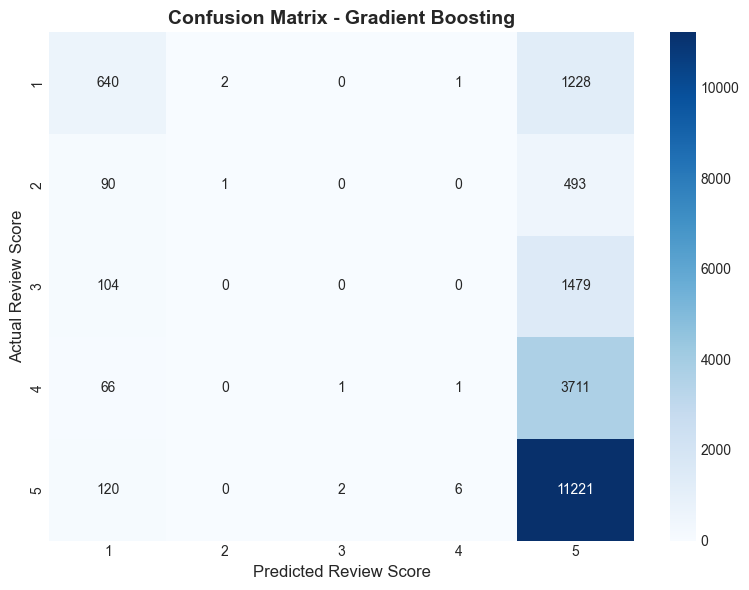


   Classification Report:
              precision    recall  f1-score   support

     Score 1       0.63      0.34      0.44      1871
     Score 2       0.33      0.00      0.00       584
     Score 3       0.00      0.00      0.00      1583
     Score 4       0.12      0.00      0.00      3779
     Score 5       0.62      0.99      0.76     11349

    accuracy                           0.62     19166
   macro avg       0.34      0.27      0.24     19166
weighted avg       0.46      0.62      0.49     19166

   ✓ Saved: reports/figures/review_feature_importance.png


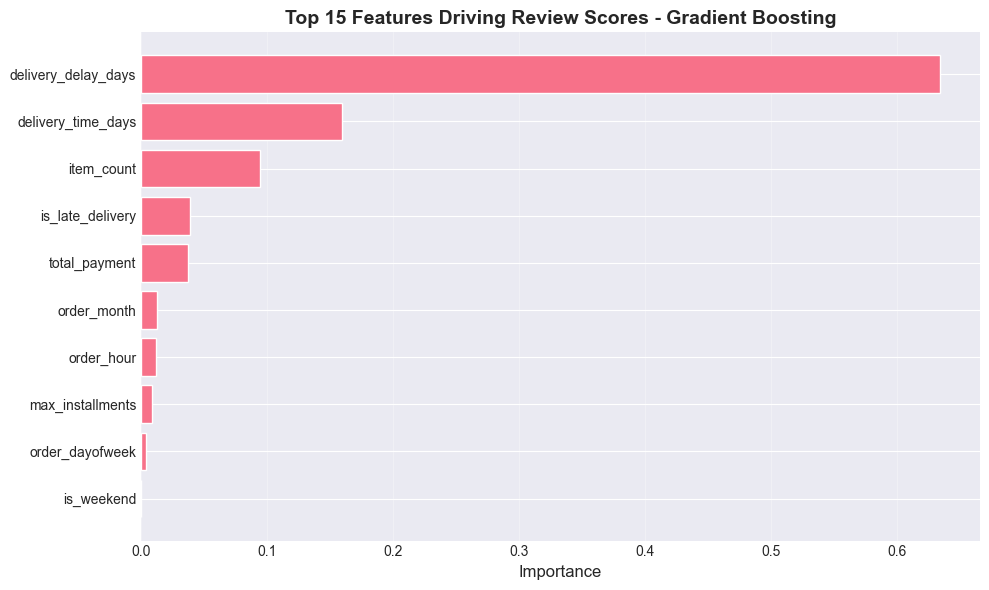


💾 SAVING MODEL
--------------------------------------------------------------------------------
   ✓ Saved: models/trained/review_model_gradient_boosting.pkl
   ✓ Saved: models/trained/review_scaler.pkl
   ✓ Saved: models/trained/review_model_metadata.pkl

✅ MODEL 4 (REVIEW SCORE PREDICTION) - COMPLETE!

📊 Summary:
   Best Model: Gradient Boosting
   Accuracy: 0.6190
   MAE: 0.7332

📁 Generated Files:
   - reports/figures/review_confusion_matrix.png
   - reports/figures/review_feature_importance.png
   - models/trained/review_model_*.pkl
   - models/trained/review_scaler.pkl
   - models/trained/review_model_metadata.pkl

🎯 Next: Model 5 - Product Recommendations


In [10]:
# Model 4 - Review Score Prediction
# ============================================================================
# Problem: Predict customer review score (1-5)
# Type: Multi-class Classification / Ordinal Regression
# Target: review_score
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("\n" + "="*80)
print(" "*20 + "MODEL 4: REVIEW SCORE PREDICTION")
print("="*80)

print("\n🎯 PROBLEM DEFINITION:")
print("   Type: Multi-class Classification (Ordinal)")
print("   Target: review_score (1-5)")
print("   Goal: Predict customer satisfaction based on order features")
print("   Business Impact: Identify factors driving bad reviews, improve service")

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("\n📁 Loading order-level data...")

# Load order features (enhanced version if available)
try:
    order_data = pd.read_csv('data/features/order_features_enhanced.csv')
    print("   ✓ Loaded: order_features_enhanced.csv")
except:
    # Fallback to master order data
    order_data = pd.read_csv('data/processed/master_order_clean.csv')
    print("   ✓ Loaded: master_order_clean.csv")

# Filter orders with reviews
order_data = order_data[order_data['review_score'].notna()].copy()

print(f"\n📊 Dataset Overview:")
print(f"   Total orders with reviews: {len(order_data):,}")
print(f"   Average review score: {order_data['review_score'].mean():.2f}")

print("\n   Review score distribution:")
print(order_data['review_score'].value_counts().sort_index())

# ============================================================================
# 2. FEATURE SELECTION
# ============================================================================
print("\n📋 Feature Selection:")

# Select relevant features for review prediction
feature_cols = []

# Delivery features (most important for reviews!)
delivery_features = ['delivery_time_days', 'is_late_delivery', 
                     'estimated_delivery_time', 'delivery_delay_days']
feature_cols.extend([col for col in delivery_features if col in order_data.columns])

# Order features
order_features = ['total_payment', 'item_count', 'freight_value', 
                  'max_installments']
feature_cols.extend([col for col in order_features if col in order_data.columns])

# Product features (if available)
product_features = ['product_category_encoded', 'product_weight_g', 
                    'product_length_cm', 'product_height_cm', 'product_width_cm']
feature_cols.extend([col for col in product_features if col in order_data.columns])

# Seller features (if available)
seller_features = ['seller_rating', 'seller_order_count']
feature_cols.extend([col for col in seller_features if col in order_data.columns])

# Time features
time_features = ['order_month', 'order_dayofweek', 'order_hour', 
                 'is_weekend', 'is_holiday']
feature_cols.extend([col for col in time_features if col in order_data.columns])

# Distance/location features
location_features = ['customer_seller_distance_km', 'same_state']
feature_cols.extend([col for col in location_features if col in order_data.columns])

print(f"   Total features available: {len(feature_cols)}")
if len(feature_cols) == 0:
    print("   ⚠ No predefined features found. Using all numeric columns...")
    # Use all numeric columns except target and IDs
    numeric_cols = order_data.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [col for col in numeric_cols if col not in 
                    ['review_score', 'order_id', 'customer_id', 'seller_id', 
                     'product_id', 'customer_unique_id']]

print(f"   Final feature count: {len(feature_cols)}")

# Prepare features and target
X = order_data[feature_cols].copy()
y = order_data['review_score'].copy()

# Handle missing values
X = X.fillna(X.median())

# Convert target to integer
y = y.astype(int)

# ============================================================================
# 3. TRAIN-TEST SPLIT
# ============================================================================
print("\n📊 Train-Test Split:")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")
print(f"   Training distribution: {y_train.value_counts().sort_index().to_dict()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# ============================================================================
# 4. TRAIN MODELS
# ============================================================================
print("\n🔨 TRAINING MODELS")
print("="*80)

review_results = {}

# 4.1 LOGISTIC REGRESSION (Ordinal)
print("\n1️⃣ LOGISTIC REGRESSION (Multiclass)")
print("-" * 80)

lr_model = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_scaled, y_train)

lr_pred = lr_model.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)

print(f"   Accuracy: {lr_acc:.4f}")
print(f"   MAE: {lr_mae:.4f}")

review_results['Logistic Regression'] = {
    'accuracy': lr_acc,
    'mae': lr_mae,
    'model': lr_model,
    'predictions': lr_pred
}

# 4.2 RANDOM FOREST
print("\n2️⃣ RANDOM FOREST CLASSIFIER")
print("-" * 80)

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

print(f"   Accuracy: {rf_acc:.4f}")
print(f"   MAE: {rf_mae:.4f}")

review_results['Random Forest'] = {
    'accuracy': rf_acc,
    'mae': rf_mae,
    'model': rf_model,
    'predictions': rf_pred
}

# 4.3 GRADIENT BOOSTING
print("\n3️⃣ GRADIENT BOOSTING CLASSIFIER")
print("-" * 80)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)
gb_model.fit(X_train, y_train)

gb_pred = gb_model.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

print(f"   Accuracy: {gb_acc:.4f}")
print(f"   MAE: {gb_mae:.4f}")

review_results['Gradient Boosting'] = {
    'accuracy': gb_acc,
    'mae': gb_mae,
    'model': gb_model,
    'predictions': gb_pred
}

# 4.4 XGBOOST
print("\n4️⃣ XGBOOST CLASSIFIER")
print("-" * 80)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    num_class=5
)
xgb_model.fit(X_train, y_train - 1)  # XGBoost expects 0-4

xgb_pred = xgb_model.predict(X_test) + 1  # Convert back to 1-5
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print(f"   Accuracy: {xgb_acc:.4f}")
print(f"   MAE: {xgb_mae:.4f}")

review_results['XGBoost'] = {
    'accuracy': xgb_acc,
    'mae': xgb_mae,
    'model': xgb_model,
    'predictions': xgb_pred
}

# 4.5 LIGHTGBM
print("\n5️⃣ LIGHTGBM CLASSIFIER")
print("-" * 80)

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42,
    verbose=-1,
    objective='multiclass',
    num_class=5
)
lgb_model.fit(X_train, y_train - 1)  # LightGBM expects 0-4

lgb_pred = lgb_model.predict(X_test) + 1  # Convert back to 1-5
lgb_acc = accuracy_score(y_test, lgb_pred)
lgb_mae = mean_absolute_error(y_test, lgb_pred)

print(f"   Accuracy: {lgb_acc:.4f}")
print(f"   MAE: {lgb_mae:.4f}")

review_results['LightGBM'] = {
    'accuracy': lgb_acc,
    'mae': lgb_mae,
    'model': lgb_model,
    'predictions': lgb_pred
}

# ============================================================================
# 5. MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("📊 MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(review_results.keys()),
    'Accuracy': [review_results[m]['accuracy'] for m in review_results.keys()],
    'MAE': [review_results[m]['mae'] for m in review_results.keys()]
})

print(comparison_df.to_string(index=False))

# Best model by accuracy
best_idx = comparison_df['Accuracy'].idxmax()
best_model_name = comparison_df.iloc[best_idx]['Model']
best_acc = comparison_df.iloc[best_idx]['Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name} (Accuracy={best_acc:.4f})")

# ============================================================================
# 6. VISUALIZATIONS
# ============================================================================
print("\n📊 GENERATING VISUALIZATIONS")
print("-" * 80)

best_model = review_results[best_model_name]['model']
best_pred = review_results[best_model_name]['predictions']

# 6.1 Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1, 2, 3, 4, 5],
            yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Review Score', fontsize=12)
plt.ylabel('Actual Review Score', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('reports/figures/review_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/review_confusion_matrix.png")
plt.show()

# 6.2 Classification Report
print("\n   Classification Report:")
print(classification_report(y_test, best_pred, target_names=[f'Score {i}' for i in range(1, 6)]))

# 6.3 Feature Importance
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    top_15 = importance_df.head(15)
    plt.barh(range(len(top_15)), top_15['Importance'])
    plt.yticks(range(len(top_15)), top_15['Feature'])
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 15 Features Driving Review Scores - {best_model_name}', 
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('reports/figures/review_feature_importance.png', dpi=300, bbox_inches='tight')
    print("   ✓ Saved: reports/figures/review_feature_importance.png")
    plt.show()

# ============================================================================
# 7. SAVE MODEL
# ============================================================================
print("\n💾 SAVING MODEL")
print("-" * 80)

model_filename = f'models/trained/review_model_{best_model_name.lower().replace(" ", "_")}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)
print(f"   ✓ Saved: {model_filename}")

# Save scaler
with open('models/trained/review_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"   ✓ Saved: models/trained/review_scaler.pkl")

# Save metadata
metadata = {
    'model_name': best_model_name,
    'metrics': {
        'accuracy': review_results[best_model_name]['accuracy'],
        'mae': review_results[best_model_name]['mae']
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_size': len(y_test),
    'train_size': len(y_train)
}

with open('models/trained/review_model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print(f"   ✓ Saved: models/trained/review_model_metadata.pkl")

# ============================================================================
# 8. FINAL REPORT
# ============================================================================
print("\n" + "="*80)
print("✅ MODEL 4 (REVIEW SCORE PREDICTION) - COMPLETE!")
print("="*80)

print(f"\n📊 Summary:")
print(f"   Best Model: {best_model_name}")
print(f"   Accuracy: {review_results[best_model_name]['accuracy']:.4f}")
print(f"   MAE: {review_results[best_model_name]['mae']:.4f}")

print("\n📁 Generated Files:")
print("   - reports/figures/review_confusion_matrix.png")
print("   - reports/figures/review_feature_importance.png")
print("   - models/trained/review_model_*.pkl")
print("   - models/trained/review_scaler.pkl")
print("   - models/trained/review_model_metadata.pkl")

print("\n🎯 Next: Model 5 - Product Recommendations")

In [13]:
# Model 5 - Product Recommendations
# ============================================================================
# Problem: Recommend products to customers
# Type: Collaborative Filtering / Content-Based Filtering
# Approach: Item-based collaborative filtering using purchase history
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import defaultdict

print("\n" + "="*80)
print(" "*20 + "MODEL 5: PRODUCT RECOMMENDATIONS")
print("="*80)

print("\n🎯 PROBLEM DEFINITION:")
print("   Type: Collaborative Filtering")
print("   Approach: Item-based (product similarity)")
print("   Goal: Recommend products based on purchase patterns")
print("   Business Impact: Cross-selling, upselling, personalized marketing")

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("\n📁 Loading order and product data...")

# Load order items (customer-product interactions)
try:
    order_items = pd.read_csv('data/processed/master_item_clean.csv')
    print("   ✓ Loaded: master_item_clean.csv")
except:
    print("   ⚠ master_item_clean.csv not found, using alternative...")
    # Fallback to creating from order data
    orders = pd.read_csv('data/processed/master_order_clean.csv')
    order_items = orders[['customer_unique_id', 'product_id', 'payment_value']].copy()

print(f"\n📊 Dataset Overview:")
print(f"   Total transactions: {len(order_items):,}")
print(f"   Unique customers: {order_items['customer_unique_id'].nunique():,}")
print(f"   Unique products: {order_items['product_id'].nunique():,}")

# ============================================================================
# 2. CREATE USER-ITEM MATRIX (SPARSE - MEMORY EFFICIENT)
# ============================================================================
print("\n🔨 Creating user-item interaction matrix...")

from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

# Encode customers and products to indices
customer_encoder = LabelEncoder()
product_encoder = LabelEncoder()

order_items['customer_idx'] = customer_encoder.fit_transform(order_items['customer_unique_id'])
order_items['product_idx'] = product_encoder.fit_transform(order_items['product_id'])

# Count purchases
interaction_data = order_items.groupby(['customer_idx', 'product_idx']).size().reset_index(name='count')

# Create sparse matrix (MUCH more memory efficient!)
n_customers = order_items['customer_idx'].nunique()
n_products = order_items['product_idx'].nunique()

print(f"\n   Creating sparse matrix: {n_customers:,} customers × {n_products:,} products")

# Check if matrix is too large
if n_customers * n_products > 100_000_000:  # 100 million cells
    print(f"   ⚠ Matrix too large ({n_customers * n_products:,} cells)")
    print(f"   → Filtering to top 5000 products only...")
    
    # Keep only top 5000 most popular products
    top_products = order_items['product_idx'].value_counts().head(5000).index
    interaction_data = interaction_data[interaction_data['product_idx'].isin(top_products)]
    
    # Re-encode products
    product_map = {old_idx: new_idx for new_idx, old_idx in enumerate(top_products)}
    interaction_data['product_idx'] = interaction_data['product_idx'].map(product_map)
    n_products = len(top_products)
    
    print(f"   → New size: {n_customers:,} × {n_products:,}")

# Create sparse matrix
sparse_matrix = csr_matrix(
    (interaction_data['count'], 
     (interaction_data['customer_idx'], interaction_data['product_idx'])),
    shape=(n_customers, n_products)
)

# Convert to dense DataFrame for smaller matrix (if manageable)
if n_customers * n_products < 50_000_000:  # 50M cells threshold
    interaction_matrix = pd.DataFrame(
        sparse_matrix.toarray(),
        index=customer_encoder.classes_,
        columns=product_encoder.classes_[:n_products]
    )
else:
    # Keep as sparse for very large matrices
    print("   → Keeping as sparse matrix (too large for dense)")
    interaction_matrix = None  # Will work with sparse

print(f"\n   Matrix shape: {sparse_matrix.shape}")
print(f"   (Customers × Products)")
print(f"   Non-zero entries: {sparse_matrix.nnz:,}")
print(f"   Sparsity: {(1 - sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))*100:.2f}%")

# ============================================================================
# 3. CALCULATE PRODUCT SIMILARITY
# ============================================================================
print("\n📊 Calculating product-product similarity...")

# Transpose to get product-product similarity
product_matrix = interaction_matrix.T

# Calculate cosine similarity between products
product_similarity = cosine_similarity(product_matrix)

# Convert to DataFrame for easier handling
product_similarity_df = pd.DataFrame(
    product_similarity,
    index=product_matrix.index,
    columns=product_matrix.index
)

print(f"   Similarity matrix shape: {product_similarity_df.shape}")
print("   ✓ Product similarity calculated")

# ============================================================================
# 4. BUILD RECOMMENDATION FUNCTION
# ============================================================================
print("\n🎯 Building recommendation engine...")

def get_product_recommendations(product_id, similarity_df, top_n=10):
    """
    Get top N similar products for a given product
    """
    if product_id not in similarity_df.index:
        return []
    
    # Get similarity scores for this product
    similar_products = similarity_df[product_id].sort_values(ascending=False)
    
    # Exclude the product itself
    similar_products = similar_products[similar_products.index != product_id]
    
    # Return top N
    return similar_products.head(top_n)

def get_user_recommendations(customer_id, interaction_matrix, similarity_df, top_n=10):
    """
    Get personalized recommendations for a customer
    """
    if customer_id not in interaction_matrix.index:
        return []
    
    # Get products the customer has purchased
    customer_products = interaction_matrix.loc[customer_id]
    purchased_products = customer_products[customer_products > 0].index.tolist()
    
    if len(purchased_products) == 0:
        return []
    
    # Calculate recommendation scores
    recommendation_scores = defaultdict(float)
    
    for product in purchased_products:
        if product in similarity_df.index:
            similar_products = similarity_df[product].sort_values(ascending=False)
            
            for similar_product, score in similar_products.items():
                # Don't recommend already purchased products
                if similar_product not in purchased_products:
                    recommendation_scores[similar_product] += score
    
    # Sort by score and return top N
    recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]

print("   ✓ Recommendation functions created")

# ============================================================================
# 5. EVALUATE RECOMMENDATIONS
# ============================================================================
print("\n📈 EVALUATING RECOMMENDATION QUALITY")
print("-" * 80)

# Sample evaluation: Check if recommendations make sense
sample_products = interaction_matrix.columns[:5].tolist()
print("\n   Sample Product Recommendations:")

for i, product in enumerate(sample_products, 1):
    recommendations = get_product_recommendations(product, product_similarity_df, top_n=5)
    if len(recommendations) > 0:
        print(f"\n   {i}. Product: {product[:20]}...")
        print(f"      Top 5 similar products:")
        for j, (rec_product, score) in enumerate(recommendations.items(), 1):
            print(f"         {j}. {rec_product[:20]}... (similarity: {score:.4f})")

# Evaluate user recommendations
sample_customers = interaction_matrix.index[:3].tolist()
print("\n   Sample Customer Recommendations:")

for i, customer in enumerate(sample_customers, 1):
    recommendations = get_user_recommendations(customer, interaction_matrix, product_similarity_df, top_n=5)
    if len(recommendations) > 0:
        print(f"\n   {i}. Customer: {customer[:20]}...")
        print(f"      Top 5 recommended products:")
        for j, (product, score) in enumerate(recommendations[:5], 1):
            print(f"         {j}. {product[:20]}... (score: {score:.4f})")

# ============================================================================
# 6. CALCULATE METRICS
# ============================================================================
print("\n📊 RECOMMENDATION METRICS")
print("-" * 80)

# Calculate coverage: % of products that can be recommended
products_with_recommendations = sum(1 for p in product_similarity_df.index 
                                    if len(get_product_recommendations(p, product_similarity_df, top_n=1)) > 0)
coverage = products_with_recommendations / len(product_similarity_df.index)

print(f"\n   Product Coverage: {coverage*100:.2f}%")
print(f"   (% of products that can receive recommendations)")

# Calculate average number of similar products per product
avg_similar_products = (product_similarity_df > 0.1).sum(axis=1).mean() - 1  # Exclude self
print(f"   Average similar products per product: {avg_similar_products:.2f}")

# Customer coverage
customers_with_purchases = (interaction_matrix.sum(axis=1) > 0).sum()
customer_coverage = customers_with_purchases / len(interaction_matrix)
print(f"   Customer Coverage: {customer_coverage*100:.2f}%")

# ============================================================================
# 7. VISUALIZATIONS
# ============================================================================
print("\n📊 GENERATING VISUALIZATIONS")
print("-" * 80)

# 7.1 Similarity Distribution
plt.figure(figsize=(10, 6))
# Get upper triangle of similarity matrix (avoid duplicates)
similarity_values = product_similarity_df.values[np.triu_indices_from(product_similarity_df.values, k=1)]
plt.hist(similarity_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Product Similarities', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/figures/recommendation_similarity_distribution.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/recommendation_similarity_distribution.png")
plt.show()

# 7.2 Purchase Distribution
plt.figure(figsize=(10, 6))
purchases_per_customer = interaction_matrix.sum(axis=1)
plt.hist(purchases_per_customer, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Products Purchased', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title('Customer Purchase Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reports/figures/recommendation_purchase_distribution.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/recommendation_purchase_distribution.png")
plt.show()

# 7.3 Product Popularity
plt.figure(figsize=(10, 6))
product_popularity = interaction_matrix.sum(axis=0).sort_values(ascending=False).head(20)
plt.barh(range(len(product_popularity)), product_popularity.values)
plt.yticks(range(len(product_popularity)), [p[:30] + '...' for p in product_popularity.index])
plt.xlabel('Number of Purchases', fontsize=12)
plt.title('Top 20 Most Popular Products', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('reports/figures/recommendation_top_products.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: reports/figures/recommendation_top_products.png")
plt.show()

# ============================================================================
# 8. SAVE RECOMMENDATION ENGINE
# ============================================================================
print("\n💾 SAVING RECOMMENDATION ENGINE")
print("-" * 80)

# Save similarity matrix
with open('models/trained/product_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(product_similarity_df, f)
print("   ✓ Saved: models/trained/product_similarity_matrix.pkl")

# Save interaction matrix
with open('models/trained/user_item_matrix.pkl', 'wb') as f:
    pickle.dump(interaction_matrix, f)
print("   ✓ Saved: models/trained/user_item_matrix.pkl")

# Save recommendation functions
recommendation_engine = {
    'get_product_recommendations': get_product_recommendations,
    'get_user_recommendations': get_user_recommendations
}
with open('models/trained/recommendation_engine.pkl', 'wb') as f:
    pickle.dump(recommendation_engine, f)
print("   ✓ Saved: models/trained/recommendation_engine.pkl")

# Save metadata
metadata = {
    'model_type': 'Item-based Collaborative Filtering',
    'num_customers': len(interaction_matrix),
    'num_products': len(interaction_matrix.columns),
    'sparsity': (1 - interaction_matrix.astype(bool).sum().sum() / (interaction_matrix.shape[0] * interaction_matrix.shape[1])),
    'coverage': coverage,
    'avg_similar_products': avg_similar_products,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('models/trained/recommendation_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("   ✓ Saved: models/trained/recommendation_metadata.pkl")

# ============================================================================
# 9. CREATE EXAMPLE USE CASES
# ============================================================================
print("\n💡 EXAMPLE USE CASES")
print("-" * 80)

print("\n   Use Case 1: Product Page - 'Customers who bought this also bought'")
if len(sample_products) > 0:
    example_product = sample_products[0]
    recommendations = get_product_recommendations(example_product, product_similarity_df, top_n=5)
    print(f"   Product: {example_product[:40]}...")
    print(f"   Recommendations: {len(recommendations)} similar products")

print("\n   Use Case 2: Personalized Email - 'Recommended for you'")
if len(sample_customers) > 0:
    example_customer = sample_customers[0]
    recommendations = get_user_recommendations(example_customer, interaction_matrix, product_similarity_df, top_n=5)
    print(f"   Customer: {example_customer[:40]}...")
    print(f"   Recommendations: {len(recommendations)} personalized products")

print("\n   Use Case 3: Cart Page - 'Complete your purchase'")
print("   → Recommend complementary products based on cart items")

# ============================================================================
# 10. FINAL REPORT
# ============================================================================
print("\n" + "="*80)
print("✅ MODEL 5 (PRODUCT RECOMMENDATIONS) - COMPLETE!")
print("="*80)

print(f"\n📊 Summary:")
print(f"   Approach: Item-based Collaborative Filtering")
print(f"   Total products: {len(interaction_matrix.columns):,}")
print(f"   Total customers: {len(interaction_matrix):,}")
print(f"   Product coverage: {coverage*100:.2f}%")
print(f"   Average similar products: {avg_similar_products:.2f}")

print("\n📁 Generated Files:")
print("   - reports/figures/recommendation_similarity_distribution.png")
print("   - reports/figures/recommendation_purchase_distribution.png")
print("   - reports/figures/recommendation_top_products.png")
print("   - models/trained/product_similarity_matrix.pkl")
print("   - models/trained/user_item_matrix.pkl")
print("   - models/trained/recommendation_engine.pkl")
print("   - models/trained/recommendation_metadata.pkl")

print("\n" + "="*80)
print("🎉 ALL 5 MODELS COMPLETE!")
print("="*80)

print("\n✅ Models Built:")
print("   1. Customer Churn Prediction ✓")
print("   2. Customer Lifetime Value (CLV) ✓")
print("   3. Revenue Forecasting ✓")
print("   4. Review Score Prediction ✓")
print("   5. Product Recommendations ✓")

print("\n🎯 Next Steps:")
print("   → Review all model outputs in reports/figures/")
print("   → Check saved models in models/trained/")
print("   → Proceed to Notebook 4: GenAI Experiments")
print("   → Build API endpoints for model deployment")
print("   → Create PowerBI dashboard")


                    MODEL 5: PRODUCT RECOMMENDATIONS

🎯 PROBLEM DEFINITION:
   Type: Collaborative Filtering
   Approach: Item-based (product similarity)
   Goal: Recommend products based on purchase patterns
   Business Impact: Cross-selling, upselling, personalized marketing

📁 Loading order and product data...
   ✓ Loaded: master_item_clean.csv

📊 Dataset Overview:
   Total transactions: 112,650
   Unique customers: 95,420
   Unique products: 32,951

🔨 Creating user-item interaction matrix...

   Creating sparse matrix: 95,420 customers × 32,951 products
   ⚠ Matrix too large (3,144,184,420 cells)
   → Filtering to top 5000 products only...
   → New size: 95,420 × 5,000
   → Keeping as sparse matrix (too large for dense)

   Matrix shape: (95420, 5000)
   (Customers × Products)
   Non-zero entries: 61,515
   Sparsity: 99.99%

📊 Calculating product-product similarity...


AttributeError: 'NoneType' object has no attribute 'T'